# Projet 5 : Segmentez des clients d'un site e-commerce

Notre objectif:

- Fournir aux équipes d’e-commerce une segmentation des clients pour les campagnes de communication
- Comprendre les différents types d’utilisateurs
- Fournir une description actionable de la segmentation
- Faire une proposition de contrat de maintenance

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from math import pi

import time
import pickle

# Création de Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Méthodes de clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

# Metrics de Clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_rand_score

In [2]:
df = pd.read_csv("data_cleaned.csv")

In [3]:
df

Unnamed: 0                          order_id  \
0                0  e481f51cbdc54678b7cc49136f2d6af7   
1                1  e481f51cbdc54678b7cc49136f2d6af7   
2                2  e481f51cbdc54678b7cc49136f2d6af7   
3                3  53cdb2fc8bc7dce0b6741e2150273451   
4                4  47770eb9100c2d0c44946d9cf07ec65d   
...            ...                               ...   
117411      118388  63943bddc261676b46f01ca7ac2f7bd8   
117412      118389  83c1379a015df1e13d02aae0204711ab   
117413      118390  11c177c8e97725db2631073c19f07b62   
117414      118391  11c177c8e97725db2631073c19f07b62   
117415      118392  66dea50a8b16d9b4dee7af250b4be1a5   

        customer_zip_code_prefix                customer_unique_id  \
0                           3149  7c396fd4830fd04220f754e42b4e5bff   
1                           3149  7c396fd4830fd04220f754e42b4e5bff   
2                           3149  7c396fd4830fd04220f754e42b4e5bff   
3                          47813  af07308b275d755c9edb36a90c618231   
4                          75265  3a653a41f6f9fc3d2a113cf8398680e8   
...                          ...                               ...   
117411                     11722  da62f9e57a76d978d02ab5362c509660   
117412                     45920  737520a9aad80b3fbbdad19b66b37b30   
117413                     28685  5097a5312c8b157bb7be58ae360ef43c   
117414                     28685  5097a5312c8b157bb7be58ae360ef43c   
117415                     83750  60350aa974b26ff12caad89e55993bd6   

       customer_city  purchase_day  purchase_month  purchase_weekday  \
0          sao paulo             2              10                 0   
1          sao paulo             2              10                 0   
2          sao paulo             2              10                 0   
3          barreiras            24               7                 1   
4         vianopolis             8               8                 2   
...              ...           ...             ...               ...   
117411  praia grande             6               2                 1   
117412   nova vicosa            27               8                 6   
117413       japuiba             8               1                 0   
117414       japuiba             8               1                 0   
117415          lapa             8               3                 3   

        purchase_hour  purchase_week  ...                         review_id  \
0                  10              0  ...  a54f0611adc9ed256b57ede6b6eb5114   
1                  10              0  ...  a54f0611adc9ed256b57ede6b6eb5114   
2                  10              0  ...  a54f0611adc9ed256b57ede6b6eb5114   
3                  20              0  ...  8d5266042046a06655c8db133d120ba5   
4                   8              0  ...  e73b67b67587f7644d5bd1a52deb1b01   
...               ...            ...  ...                               ...   
117411             12              1  ...  29bb71b2760d0f876dfa178a76bc4734   
117412             14              0  ...  371579771219f6db2d830d50805977bb   
117413             21              0  ...  8ab6855b9fe9b812cd03a480a25058a1   
117414             21              0  ...  8ab6855b9fe9b812cd03a480a25058a1   
117415             20              0  ...  dc9c59b4688062c25758c2be4cafc523   

              review_answer_timestamp   order_delivered_carrier_date  \
0       2017-10-12 03:43:48.000000000  2017-10-04 19:55:00.000000000   
1       2017-10-12 03:43:48.000000000  2017-10-04 19:55:00.000000000   
2       2017-10-12 03:43:48.000000000  2017-10-04 19:55:00.000000000   
3       2018-08-08 18:37:50.000000000  2018-07-26 14:31:00.000000000   
4       2018-08-22 19:07:58.000000000  2018-08-08 13:50:00.000000000   
...                               ...                            ...   
117411  2018-03-02 17:50:01.000000000  2018-02-07 23:22:42.000000000   
117412  2017-09-22 23:10:57.000000000  2017-08-28 20:52:26.000000000   
117413  2018-01-27 09:16:56.0000

# 1. Segmentation clientèle


- Récence indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client.
- Fréquence est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.
- Montant est la somme totale qu'un client dépense sur une période donnée

In [4]:
# On s'intèresse à une période d'une année entière, soit 365 jours
period = 365
# Séléction des variables permettant le calcul RFM
data = df[["customer_id", "purchase_time", "payment_value"]]
# Jour actuel : date de la dernière commande
# Jour actuel : date de la dernière commande
data["purchase_time"] = data["purchase_time"].astype('datetime64[ns]')
today = data["purchase_time"].max() + timedelta(days=1)

In [5]:
def calculate_rfm(data, period, today):
    """
    Calcul des valeurs R, F et M.

    ParamÃ¨tres:
    data(pd.DataFrame): doit contenir les colonnes 'payment_value',
    'purchase_time' et 'customer_id'
    period(int): Nombre de jours
    today(dt.datetime): date de fin de pÃ©riode

    Return:
    rfm(pd.DataFrame): retourne un pd.DataFrame avec les variables Recency,
    Frequency et Monetary
    """

    data = data.loc[data["purchase_time"] >= today - timedelta(days=period)]
    # Nombre de jours passés entre aujourd'hui
    # et la dernière commande de chaque utilisateur
    data.loc[:, "DaysSinceOrder"] = data.loc[:, "purchase_time"] \
                                        .map(lambda d: (today - d).days)

    aggr = {
            'DaysSinceOrder': lambda x: x.min(),
            # Nombre de jours depuis la dernière commande (Recency)
            'purchase_time': lambda x:
            len([d for d in x if d >= today - timedelta(days=period)]),
            # le nombre total de transactions sur la période passée (Frequency)
    }

    rfm = data.groupby('customer_id').agg(aggr).reset_index()
    rfm.rename(columns={'DaysSinceOrder': 'Recency',
                        'purchase_time': 'Frequency'},
               inplace=True)

    # Montant total de toutes les transactions sur la période définie
    rfm['Monetary'] = rfm.loc[:, 'customer_id'].apply(lambda x:
                              data.loc[data['customer_id'] ==
                                       x, 'payment_value'].sum())

    # Affichage des 5 premières lignes
    rfm.head()

    return rfm

In [6]:
# Calcul RFM, entre la date de la dernière commande et il y a 365 jours
rfm_1 = calculate_rfm(data, period, today)

In [7]:
# Affichage des 5 premières lignes
rfm_1.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74
1  000379cdec625522490c315e70c7a9fb      154          1    107.01
2  000419c5494106c306a97b5635748086      185          1     49.40
3  00046a560d407e99b969756e0b10f282      259          1    166.59
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23

Interprétation :

- customer_id 00012a2ce6f8dcda20d059ce98491703 a fait son premier et dernier achat il y a 293 jours, pour un montant total de 114.74 R$

- customer_id 00050bf6e01e69d5c0fd612f1bcfb69c a fait son premier et dernier achat il y a 351 jours, pour un montant total de 85.23 R$

In [8]:
rfm_1.shape

(74766, 4)

In [9]:
number_of_customers = rfm_1["customer_id"].nunique()

In [10]:
number_of_customers

74766

In [11]:
# Description arithmétique des données
rfm_1.describe()

Recency     Frequency       Monetary
count  74766.000000  74766.000000   74766.000000
mean     177.777305      1.192895     207.845740
std       98.732912      0.703309     659.534962
min        1.000000      1.000000       9.590000
25%       94.000000      1.000000      63.162500
50%      178.000000      1.000000     111.120000
75%      265.000000      1.000000     196.542500
max      364.000000     38.000000  109312.640000

In [12]:
print("Le nombre de clients ayant commandé plus d'une fois est de : {:.2f} %"
      .format(100*sum(rfm_1["Frequency"] > 1)/len(rfm_1)))

Le nombre de clients ayant commandé plus d'une fois est de : 12.77 %


In [13]:
def plot_hist(rfm, figsize=(20, 10)):

    plt.figure(1, figsize=figsize)

    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(rfm[col],
                 bins=int(1 + np.log2(len(rfm))),
                 label='skweness : ' + str(round(rfm[col].skew(), 2)),
                 density=True)
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
    plt.show()

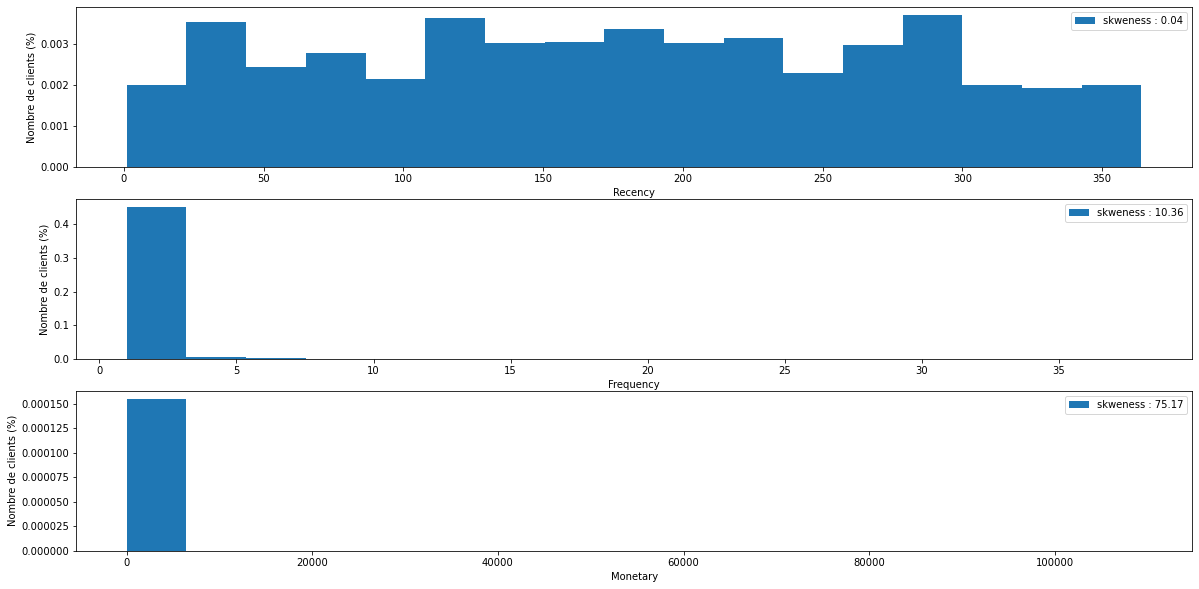

In [14]:
# Histogramme des variables 'Recency', 'Frequency' et 'Monetary'
plot_hist(rfm_1.drop(columns='customer_id'))


Les variables 'Frequency' et 'Monetary' présentent une forte asymétrie dont il est nécessaire de corriger. Une règle habituelle consiste à appliquer un logarithme aux variables dont le skewness est supérieur à 1 en valeur absolue. De ce fait, nous allons logarithmer les variables 'Frequency' et 'Monetary'.

In [15]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_1 = rfm_1.copy()
rfm_log_1[["Frequency",
           "Monetary"]] = rfm_log_1[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

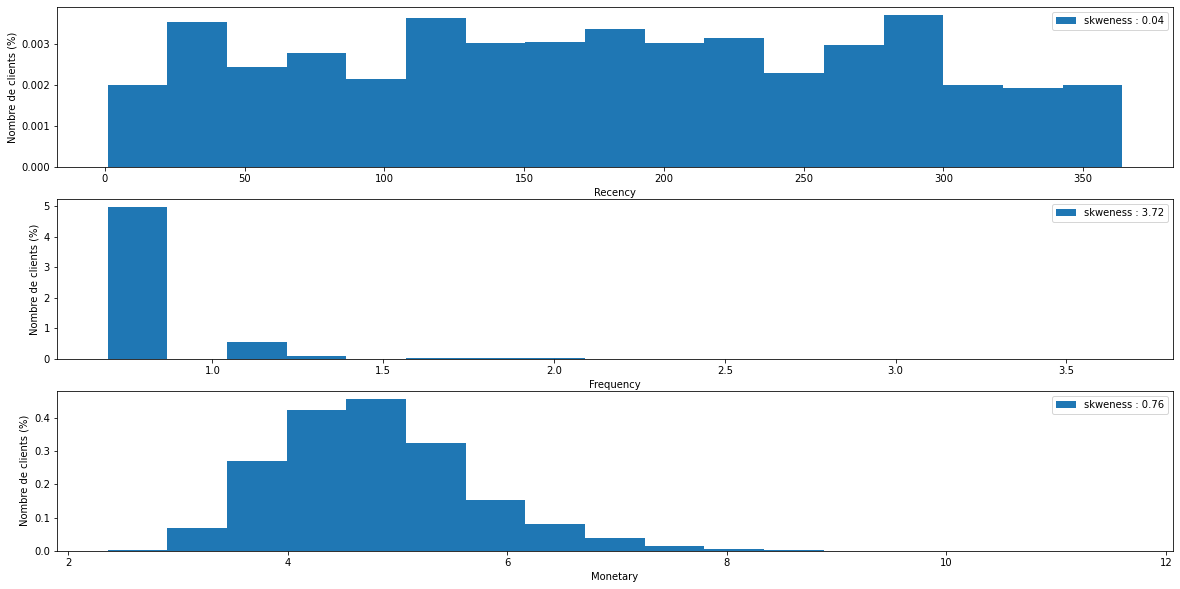

In [16]:
# Nouvelle distribution des variables logarithmés
plot_hist(rfm_log_1.drop(columns='customer_id'))

Les skewness des variables étudiés sont soit passés en dessous de 1 soit beaucoup plus proches de 1, ce qui montre l'efficacité de l'application du logarithme sur nos variables

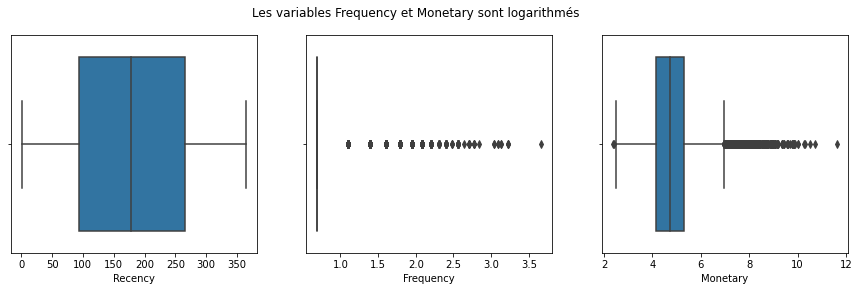

In [17]:
fig = plt.figure(1, figsize=(15, 4))

plt.suptitle("Les variables Frequency et Monetary sont logarithmés")

# Boxplot de la variable Recency
plt.subplot(131)
sns.boxplot(rfm_log_1["Recency"], orient="vertical")

# Boxplot de la variable Frequency
plt.subplot(132)
sns.boxplot(rfm_log_1["Frequency"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(133)
sns.boxplot(rfm_log_1["Monetary"], orient="vertical")
plt.show()

In [18]:
print("L'essentiel des montants se situe autour de la médiane qui est de {}. \n"
      "Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois."
      .format(rfm_1["Monetary"].median(), rfm_1["Frequency"].median()))

L'essentiel des montants se situe autour de la médiane qui est de 111.12. 
Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois.


# RFM Score

La méthode:
- consiste à quantiliser chaque segment RFM de manière à obtenir un score entre 1 et 5 pour chaque variable R, F et M.

En fonction de chaque score obtenu, le client sera attribué dans une catégorie.

## Calcul des quantiles


In [19]:
def r_score(x, quintiles):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribut un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['Recency',
                     'Frequency',
                     'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [20]:
# Calcul des quantiles
rfm_table_1 = calculate_quantile(rfm_1)

In [21]:
rfm_table_1.head()

customer_id  Recency  Frequency  Monetary  R  F  M
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2

In [22]:
rfm_table_1.head()

customer_id  Recency  Frequency  Monetary  R  F  M
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2

## Calcul des segments et des scores

Chaque client est caractérisé en fonction de la note pour chaque variable R, F M qui le caractérise

9 segments sont définis :

- Champions : achats récents, achète souvent et dépense beaucoup
- Loyal Customers : achètent régulièrement, sensibles aux promotions
- Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne
- Recent Customers : achats récents, mais peu fréquents
- Promising : nouveaux acheteurs, mais peu dépensiers
- Need Attention : dépenses moyennes, moyennement fréquemment, achat moyennement récent
- About to Sleep : client qui tendent à disparaitre
- Can't Lose Them : achètaient régulièrement, besoin de les faire revenir
- At Risk : dépensaient beaucoup, achetaient souvent mais il y a lomgtemps
- Lost : peu dépensiers, peu fréquements, a acheté il y a un moment
- Others : pas catégorisable

In [23]:
# Etiquette des catégories pour la méthodologie 1
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About to Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [24]:
def calculate_segments(rfm):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """

    if 4 <= rfm["R"] <= 5 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Champions"

    elif 3 <= rfm["R"] <= 5 and 3 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["R"] <= 5 and 1 <= rfm["F"] <= 3 and 1 <= rfm["M"] <= 3:
        return "Potential Loyalist"

    elif rfm["R"] >= 4 and rfm["F"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["R"] <= 4 and rfm["F"] <= 1 and rfm["M"] <= 1:
        return "Promising"

    elif 2 <= rfm["R"] <= 3 and 2 <= rfm["F"] <= 3 and 2 <= rfm["M"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["R"] <= 3 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "About to Sleep"

    elif rfm["R"] <= 1 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Can't Lose Them"

    elif rfm["R"] <= 2 and 2 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "At Risk"

    elif rfm["R"] <= 2 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "Lost"

    else:
        return "Others"

## Attribution des catégories


In [25]:
# RFM Score
rfm_table_1["RFM Score"] = rfm_table_1.apply(calculate_segments, axis=1)

## Apperçu des résultats


In [26]:
# Affiche les 5 premières lignes
rfm_table_1.head(10)

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4   
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2   
5  000598caf2ef4117407665ac33275130       23          1   1255.71  5  1  5   
6  0005aefbb696d34b3424dccd0a0e9fd0       75          1    147.33  5  1  4   
7  00066ccbe787a588c52bd5ff404590e3      209          4   1080.00  3  5  5   
8  000bf8121c3412d3057d32371c5d3395      328          2     91.12  1  5  3   
9  000f17e290c26b28549908a04cfe36c1      297          1    139.52  1  1  4   

            RFM Score  
0              Others  
1  Potential Loyalist  
2  Potential Loyalist  
3              Others  
4                Lost  
5    Recent Customers  
6    Recent Customers  
7     Loyal Customers  
8             At Risk  
9              Others

## Résumé des résultats de la segmentation

In [27]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']
# Regroupement des données
qtd_preco = rfm_table_1.groupby(['RFM Score'])
# Aggrégation des données par différentes fonctions
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)
# Affichage de la table de résumé
summery_table

Recency                                         Frequency  \
                     count  min        mean median  max        std     count   
RFM Score                                                                      
About to Sleep        5773  210  244.149662  240.0  279  21.479981      5773   
At Risk               2084  210  255.039347  247.0  364  34.994264      2084   
Can't Lose Them       1646  280  313.221750  309.0  364  26.089908      1646   
Champions             3000    5   79.636000   82.0  145  40.615096      3000   
Lost                  5891  280  315.123918  313.0  364  26.677116      5891   
Loyal Customers       2375    6  155.486316  168.0  209  48.410703      2375   
Others               19030    7  253.800420  259.0  364  60.312196     19030   
Potential Loyalist   25759    5  109.886292  114.0  209  59.772294     25759   
Recent Customers      9208    1   77.127606   77.0  145  40.734418      9208   

                                                      Monetary          \
                   min      mean median max       std    count     min   
RFM Score                                                                
About to Sleep       1  1.000000    1.0   1  0.000000     5773   13.78   
At Risk              2  2.443858    2.0  21  1.236435     2084   55.28   
Can't Lose Them      2  2.623937    2.0  38  1.672996     1646  137.99   
Champions            2  2.552000    2.0  24  1.351260     3000  137.96   
Lost                 1  1.000000    1.0   1  0.000000     5891   10.07   
Loyal Customers      2  2.458105    2.0  24  1.281319     2375   55.34   
Others               1  1.032633    1.0  22  0.291842    19030    9.59   
Potential Loyalist   1  1.000000    1.0   1  0.000000    25759   10.89   
Recent Customers     1  1.000000    1.0   1  0.000000     9208  137.94   

                                                                 
                          mean   median        max          std  
RFM Score                                                        
About to Sleep       54.922884   55.090      88.81    18.490806  
At Risk             486.480662  259.440   21874.05  1007.733046  
Can't Lose Them     829.442983  380.985  109312.64  3154.296129  
Champions           728.252057  400.190   30186.00  1384.261283  
Lost                 56.357141   56.970      88.76    18.072385  
Loyal Customers     489.338615  233.160   44048.00  1258.644864  
Others              235.269789  168.200    4175.26   234.724673  
Potential Loyalist   73.717384   69.370     137.93    31.686811  
Recent Customers    302.848657  204.400    4681.78   299.200809

## Visualisation graphique 3d des différents clients associés à leur catégorie

In [28]:
# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(categories_1))
colors_1 = {label: color for label, color in zip(categories_1,
                                                 palette_1.as_hex())}

In [29]:
def projection_3d_segments(rfm_table, label_score, colors) :
    """
    Graphique montrant les différents clients associés à leur segment/cluster respectif
    rfmTable(pd.DataFrame): Table de résultats
    label_score(str): nom de la segmentation
    colors(list): liste de couleurs

    """
    fig = plt.figure(1, figsize=(18, 8))

    dx = fig.add_subplot(111, projection='3d')
    # Pour chaque segment, scatter plot des individus avec code couleur
    for i, segment in enumerate(rfm_table[label_score].unique()):
        dx.scatter(rfm_table[rfm_table[label_score] == segment].Recency,
                   rfm_table[rfm_table[label_score] == segment].Frequency,
                   rfm_table[rfm_table[label_score] == segment].Monetary,
                   label=segment,
                   s=50,
                   c=colors[segment])
    # Titre des axes et titre graphique
    dx.set_xlabel("Recency")
    dx.set_ylabel("Frequency")
    dx.set_zlabel("Monetary")
    plt.title("Représentation 3D des différents individus dans chaque segment")

    plt.legend()
    plt.show()

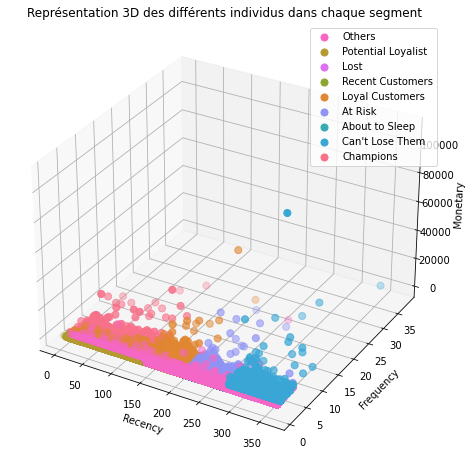

In [30]:
# Graphique 3D (x, y, z) = (Recency, Frequency, Monetary)
projection_3d_segments(rfm_table_1, 'RFM Score', colors_1)

On visualise graphiquement ici la nature très rectiligne de la segmentation

In [31]:
def projection_2d_segments(rfm_table, xlabel, ylabel, label_score, colors) :
    """
    2D scatter plot
    data(pd.DataFrame): contient les 3 colonnes xlabel, ylabel et label_score
    xlabel(str): nom colonne data pour l'axe des x
    ylabel(str): nom colonnne data pour l'axe des y
    label_score: nom méthodologie de la segmentation
    """
    # Pour chaque segment, scatter plot
    for i, segment in enumerate(rfm_table[label_score].unique()):
        plt.scatter(rfm_table[rfm_table[label_score] == segment][xlabel],
                    rfm_table[rfm_table[label_score] == segment][ylabel],
                    label=segment,
                    c=colors[segment]
                   )
    # Titre des axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

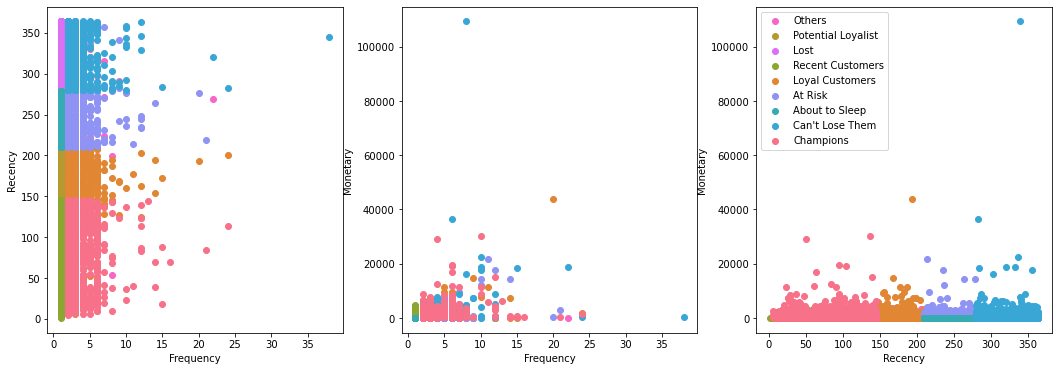

In [32]:
plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Recency",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfm_table_1,
                       "Recency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

plt.legend()
plt.show()

# KMeans


## Normalisation des données

In [154]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_1 = encoder.fit_transform(
    rfm_log_1[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_1 = pd.DataFrame(x_transformed_1,
                         index=rfm_1.index,
                         columns=["Recency", "Frequency", "Monetary"])

## Clusterisation avec k-means

Dans cette partie, nous allons déterminer quel est le nombre de clusters qui nous permet d'avoir les meilleurs résultats.

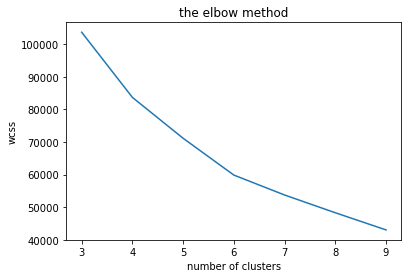

In [155]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_1)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the elbow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

In [35]:
def clustering_rfm(rfm, range_n_clusters):
    """
    Cette fonction teste pour différents nombre de clusters,
    un clustering des données par la méthode k-means.
    La fonction affiche le score de silhouette pour chacun des clusters,
    ainsi que la répartition des données dans l'espace RFM
    et leurs codes couleurs associés en fonction de leur appartenance
    aux différents clusters déterminés.

    Parametres:
    rfm (pd.DataFrame): DataFrame avec 3 colonnes nommés :
    Recency, Frequency and Monetary

    Return :
    list: Liste des valeurs d'intertie pour différents nombre de clusters
    """

    # Liste des valeurs d'inertie
    wcss = []
    # Temps d'entrainement
    fit_predict_time = []
    # Score de silhouette
    silhouette_score_avg = []

    palette = sns.color_palette("husl", max(range_n_clusters))
    colors = palette.as_hex()

    rfm_ = rfm.copy()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig = plt.figure(1, figsize=(18, 7))
        ax1 = fig.add_subplot(121)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example
        # all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++',
                           random_state=10)
        start_time = time.time()
        cluster_labels = clusterer.fit_predict(rfm)
        time.time() - start_time

        fit_predict_time.append(time.time() - start_time)
        wcss.append(clusterer.inertia_)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation
        # of the formed clusters
        silhouette_score_avg.append(silhouette_score(rfm, cluster_labels))


        # Compute the silhouette scores for each sample
        sample_silh_values = silhouette_samples(rfm, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silh_values = sample_silh_values[cluster_labels == i]

            ith_cluster_silh_values.sort()

            size_cluster_i = ith_cluster_silh_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silh_values,
                              facecolor=colors[i],
                              edgecolor=colors[i],
                              alpha=0.7)

            # Label the silhouette plots with
            # their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_score_avg[-1], color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        dx = fig.add_subplot(122, projection='3d')

        rfm_["clusters"] = cluster_labels
        for i in range(n_clusters):
            dx.scatter(rfm_[rfm_.clusters == i].Recency,
                       rfm_[rfm_.clusters == i].Frequency,
                       rfm_[rfm_.clusters == i].Monetary,
                       c=colors[i],
                       label='Cluster ' + str(i+1),
                       s=50)

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            dx.scatter(centers[:, 0],
                       centers[:, 1],
                       centers[:, 2],
                       marker='o',
                       c="white",
                       alpha=1,
                       s=200,
                       edgecolor='k')

            for i, c in enumerate(centers):
                dx.scatter(c[0],
                           c[1],
                           c[2],
                           marker='$%d$' % i,
                           alpha=1,
                           s=50,
                           edgecolor='k')
        # Titres des axes
        dx.set_xlabel("Recency")
        dx.set_ylabel("Frequency")
        dx.set_zlabel("Monetary")

        plt.suptitle(("Silhouette analysis for k-means clustering "
                      "on sample data with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

        print("Pour n_clusters =", n_clusters, "\n",
              "Le silhouette score moyen est de :",
              round(silhouette_score_avg[-1], 2), "\n",
              "Le temps d'entrainement du modèle est de :",
              round(fit_predict_time[-1], 2))

    return wcss, silhouette_score_avg, fit_predict_time  # Inertie

In [36]:
# Résultats kmeans pour différents nombre de clusters
range_n_clusters = range(3, 9)

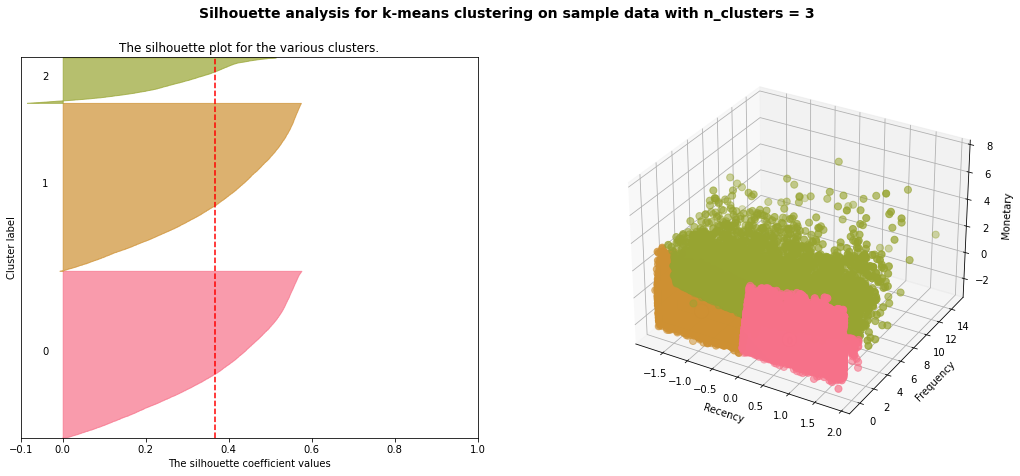

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.37 
 Le temps d'entrainement du modèle est de : 0.14


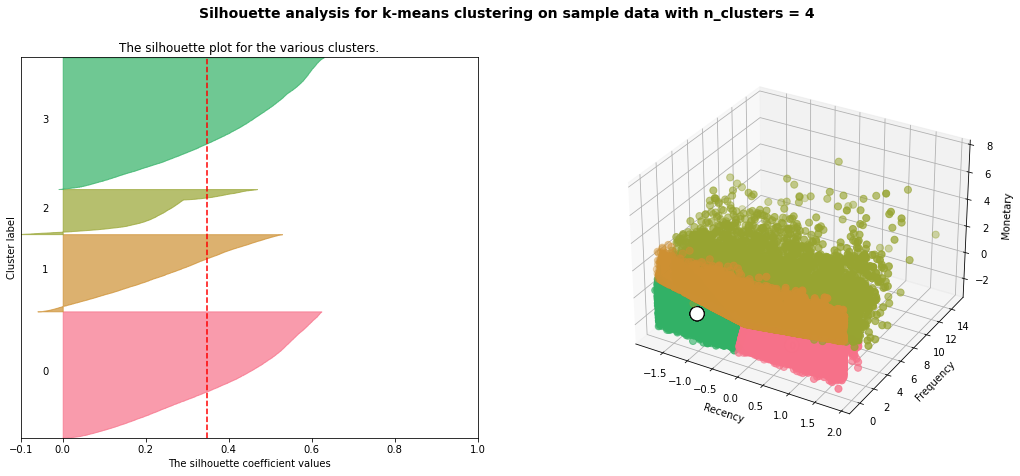

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 0.38


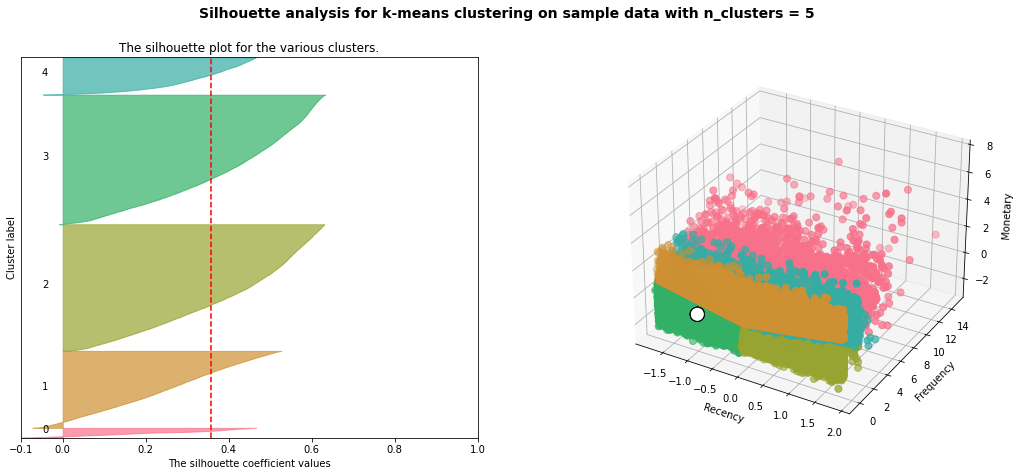

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.36 
 Le temps d'entrainement du modèle est de : 0.39


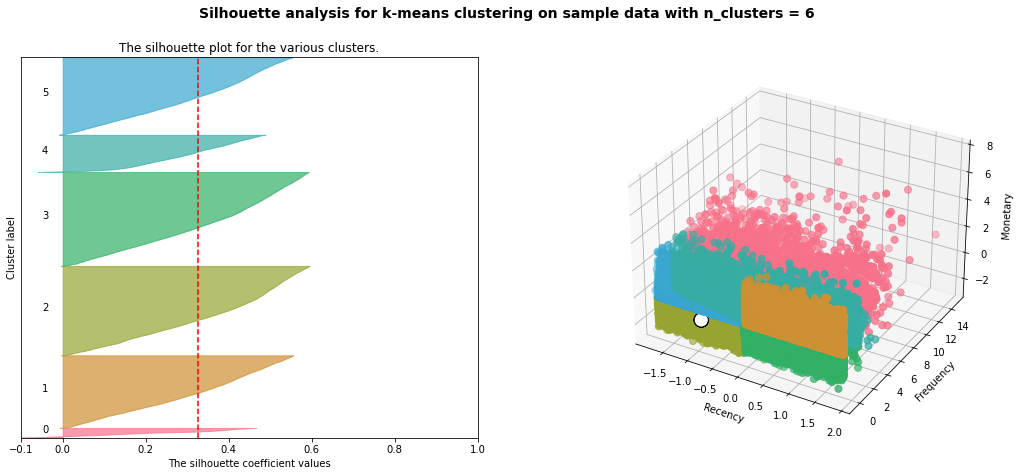

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.39


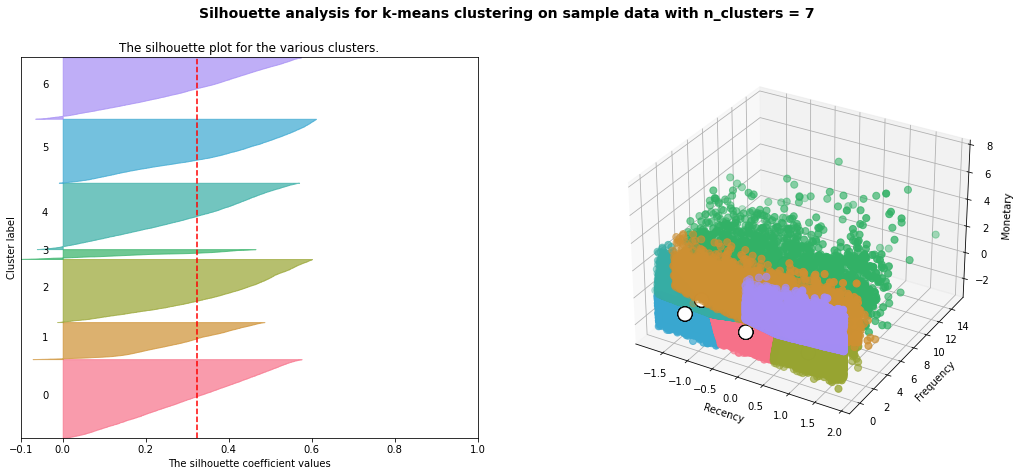

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.32 
 Le temps d'entrainement du modèle est de : 0.43


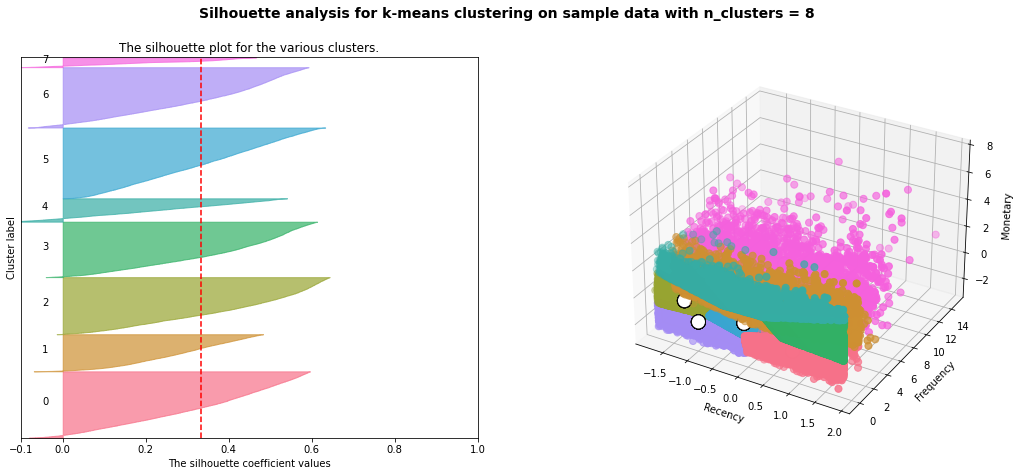

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.48


In [46]:
fit_predict_time = clustering_rfm(rfm_std_1,range_n_clusters)

Le silhouette score est le deuxième plus élevé pour n_clusters=6

C'est donc n_clusters=6 qui est choisi pour la suite de l'étude

In [156]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 1
clusters = kmeans.fit_predict(x_transformed_1)
rfm_table_1['clusters'] = clusters

In [157]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']

# Les données sont groupés par clusters
qtd_preco = rfm_table_1.groupby(['clusters'])

# Aggrégation des données
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage des résultats
summery_table

Recency                                         Frequency      \
           count  min        mean median  max        std     count min   
clusters                                                                 
0          17654    5   91.829897   92.0  178  50.508587     17654   1   
1          14296  178  262.133114  265.0  364  52.096282     14296   1   
2           1939    6  187.804023  188.0  364  98.500249      1939   2   
3           7306    5  180.253490  181.0  364  96.349747      7306   2   
4          18417  177  262.037574  264.0  364  52.234250     18417   1   
5          15154    1   93.443843   94.0  177  49.557793     15154   1   

                                        Monetary                               \
              mean median max       std    count     min         mean  median   
clusters                                                                        
0         1.007590    1.0   2  0.086794    17654    9.59    63.289168   62.25   
1         1.000000    1.0   1  0.000000    14296  110.55   251.359617  177.16   
2         4.308922    4.0  38  2.238830     1939   19.35  1582.182955  836.20   
3         2.054065    2.0   4  0.233312     7306   17.38   364.557038  270.00   
4         1.009285    1.0   2  0.095912    18417   10.07    63.711634   62.88   
5         1.000000    1.0   1  0.000000    15154  109.21   258.965743  176.04   

                                  
                max          std  
clusters                          
0            110.63    24.219252  
1           3826.80   232.162805  
2         109312.64  3586.968406  
3           5277.28   372.862734  
4            110.90    24.082939  
5           4681.78   271.828559

In [158]:
rfm_table_1.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4   
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2   

            RFM Score  clusters  
0              Others         1  
1  Potential Loyalist         0  
2  Potential Loyalist         4  
3              Others         1  
4                Lost         4

In [159]:
kmeans_clusters_means = rfm_table_1.groupby("clusters").median()
kmeans_clusters_means

Recency  Frequency  Monetary    R    F    M
clusters                                             
0            92.0        1.0     62.25  4.0  1.0  2.0
1           265.0        1.0    177.16  2.0  1.0  4.0
2           188.0        4.0    836.20  3.0  5.0  5.0
3           181.0        2.0    270.00  3.0  5.0  5.0
4           264.0        1.0     62.88  2.0  1.0  2.0
5            94.0        1.0    176.04  4.0  1.0  4.0

In [160]:
kmeans_clusters_means["F"]=kmeans_clusters_means["F"].astype(int)
kmeans_clusters_means["R"]=kmeans_clusters_means["R"].astype(int)
kmeans_clusters_means["M"]=kmeans_clusters_means["M"].astype(int)

In [161]:
kmeans_clusters_means

Recency  Frequency  Monetary  R  F  M
clusters                                       
0            92.0        1.0     62.25  4  1  2
1           265.0        1.0    177.16  2  1  4
2           188.0        4.0    836.20  3  5  5
3           181.0        2.0    270.00  3  5  5
4           264.0        1.0     62.88  2  1  2
5            94.0        1.0    176.04  4  1  4

In [162]:
kmeans_clusters_means = kmeans_clusters_means.assign(RFM = kmeans_clusters_means.R.astype(str) + kmeans_clusters_means.F.astype(str) + kmeans_clusters_means.M.astype(str))

In [163]:
kmeans_clusters_means

Recency  Frequency  Monetary  R  F  M  RFM
clusters                                            
0            92.0        1.0     62.25  4  1  2  412
1           265.0        1.0    177.16  2  1  4  214
2           188.0        4.0    836.20  3  5  5  355
3           181.0        2.0    270.00  3  5  5  355
4           264.0        1.0     62.88  2  1  2  212
5            94.0        1.0    176.04  4  1  4  414

In [45]:
del kmeans_clusters_means["Recency"]
del kmeans_clusters_means["Frequency"]
del kmeans_clusters_means["Monetary"]
del kmeans_clusters_means["RFM"]


In [46]:
kmeans_clusters_means.transpose()

clusters  0  1  2  3  4  5
R         4  2  3  3  2  4
F         1  1  5  5  1  1
M         2  4  5  5  2  4

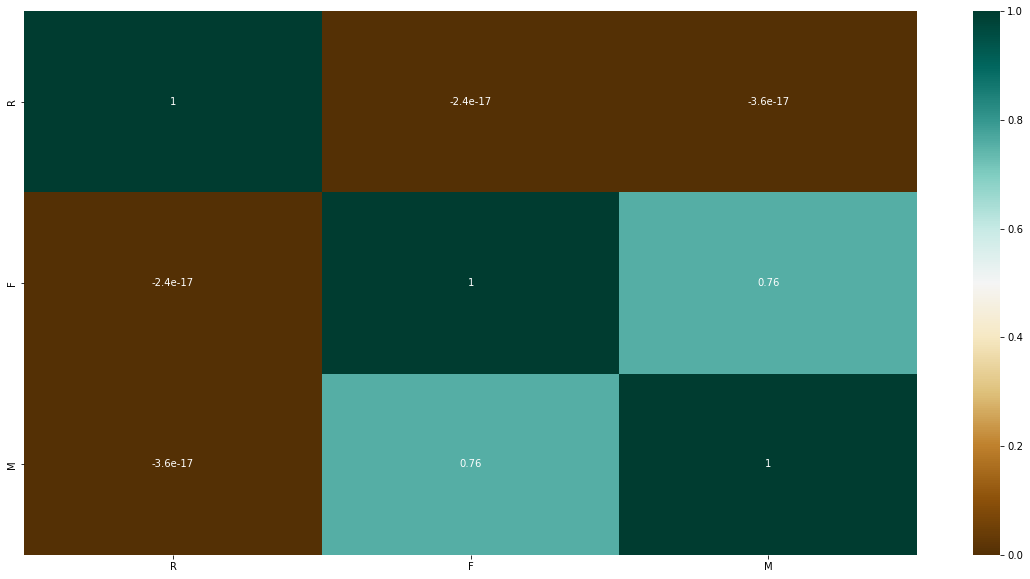

In [47]:
plt.figure(figsize=(20,10))
sns.heatmap(kmeans_clusters_means.corr(), annot=True, cmap='BrBG')
plt.show()

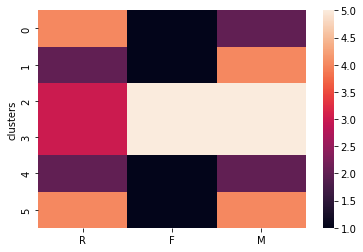

In [48]:
ax = sns.heatmap(kmeans_clusters_means)

## Etiquettage des clusters

In [49]:
# Etiquettage des différents clusters
categories_2 = [
                "Others",
                "Potential Loyalist",
                'Lost or About to Sleep',
                "Top Clients ++",
                "Recent Customers",
                "Good Clients",
]

In [50]:
# Renommage des différents clusters et regroupement
rfm_table_1.loc[rfm_table_1["clusters"] ==
               3, "clusters"] = 'Good Clients'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_table_1.loc[rfm_table_1["clusters"] ==
               0, "clusters"] = 'Others'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

Descriptifs du clustering des consommateurs :
- Top Clients ++ : Il s'agit des grands comptes, les individus dépensent très régulièrement des grandes quantitées d'argent

- Good Clients : Ils arrivent après les grandes comptes, les sommes d'argents dépensés sont conséquentes et la fréquence élevé

- Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne

- Recent Customers : achats récents, mais peu fréquents

- Lost or About to Sleep: clients qui n'ont pas effectués d'achat cette année ou qui tendent à disparaitre

- Others : pas catégorisable

In [51]:
rfm_table_1.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4   
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2   

            RFM Score                clusters  
0              Others      Potential Loyalist  
1  Potential Loyalist                  Others  
2  Potential Loyalist  Lost or About to Sleep  
3              Others      Potential Loyalist  
4                Lost  Lost or About to Sleep

In [52]:
nc = ['count', 'min', 'mean', 'median', 'max', 'std']
qtd_preco = rfm_table_1.groupby(['clusters'])
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage des résultats
summery_table

Recency                                          \
                         count  min        mean median  max        std   
clusters                                                                 
Good Clients              7306    5  180.253490  181.0  364  96.349747   
Lost or About to Sleep   18417  177  262.037574  264.0  364  52.234250   
Others                   17654    5   91.829897   92.0  178  50.508587   
Potential Loyalist       14296  178  262.133114  265.0  364  52.096282   
Recent Customers         15154    1   93.443843   94.0  177  49.557793   
Top Clients ++            1939    6  187.804023  188.0  364  98.500249   

                       Frequency                                    Monetary  \
                           count min      mean median max       std    count   
clusters                                                                       
Good Clients                7306   2  2.054065    2.0   4  0.233312     7306   
Lost or About to Sleep     18417   1  1.009285    1.0   2  0.095912    18417   
Others                     17654   1  1.007590    1.0   2  0.086794    17654   
Potential Loyalist         14296   1  1.000000    1.0   1  0.000000    14296   
Recent Customers           15154   1  1.000000    1.0   1  0.000000    15154   
Top Clients ++              1939   2  4.308922    4.0  38  2.238830     1939   

                                                                             
                           min         mean  median        max          std  
clusters                                                                     
Good Clients             17.38   364.557038  270.00    5277.28   372.862734  
Lost or About to Sleep   10.07    63.711634   62.88     110.90    24.082939  
Others                    9.59    63.289168   62.25     110.63    24.219252  
Potential Loyalist      110.55   251.359617  177.16    3826.80   232.162805  
Recent Customers        109.21   258.965743  176.04    4681.78   271.828559  
Top Clients ++           19.35  1582.182955  836.20  109312.64  3586.968406

In [53]:
# Liste des couleurs pour chaque segment
palette_2 = sns.color_palette("husl", len(categories_2))
colors_2 = {label: color for label, color in zip(categories_2,
                                                 palette_2.as_hex())}

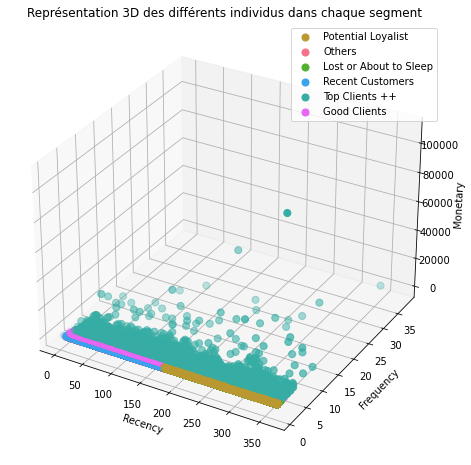

In [54]:
# Projection 3D : Rencency vs Frequency vs Monetary
projection_3d_segments(rfm_table_1, 'clusters', colors_2)

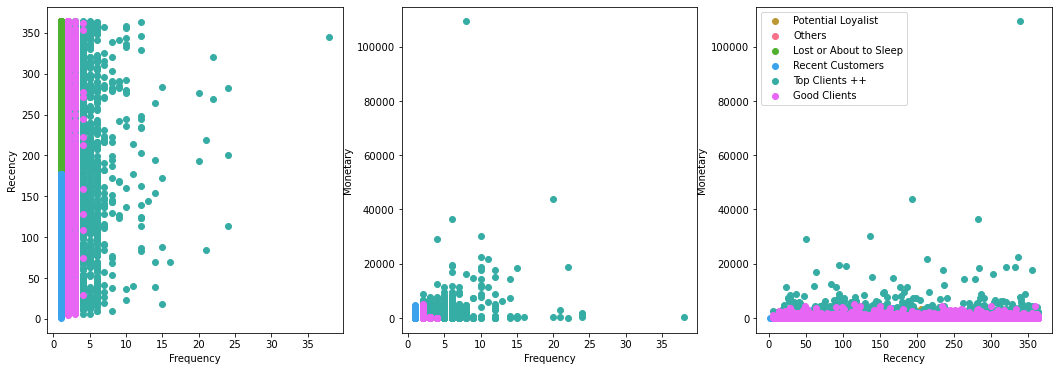

In [55]:
fig = plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Recency",
                       "clusters",
                       colors_2)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Monetary",
                       "clusters",
                       colors_2)

# 2D plot, Recency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfm_table_1,
                       "Recency",
                       "Monetary",
                       "clusters",
                       colors_2)

plt.legend()
plt.show()

# DBSCAN

In [56]:
rfm_std_1.shape

(74766, 3)

In [57]:
rfm_std_2=rfm_std_1.sample(37383)

In [58]:
rfm_std_2.shape

(37383, 3)

In [59]:
#eps=0.25
clusters = DBSCAN(eps = 0.25, min_samples =50, metric='euclidean',n_jobs=1).fit(rfm_std_2)
labels = clusters.labels_

In [60]:
np.unique(labels)

array([-1,  0,  1])

In [61]:
#eps=0.5
clusters = DBSCAN(eps = 0.5, min_samples =50, metric='euclidean',n_jobs=1).fit(rfm_std_2)
labels = clusters.labels_

In [62]:
np.unique(labels)

array([-1,  0,  1,  2])

In [63]:
#eps=0.75
clusters = DBSCAN(eps = 0.75, min_samples =50, metric='euclidean',n_jobs=1).fit(rfm_std_2)
labels = clusters.labels_

In [64]:
np.unique(labels)

array([-1,  0,  1,  2,  3])

In [65]:
#eps=1.05
clusters = DBSCAN(eps =1.05, min_samples =50, metric='euclidean',n_jobs=1).fit(rfm_std_2)
labels = clusters.labels_

In [66]:
np.unique(labels)

array([-1,  0,  1,  2,  3])

In [67]:
pd.Series(labels).value_counts()

 0    32662
 1     3537
 2      595
 3      396
-1      193
dtype: int64

In [68]:
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 1.05, min_samples =300,metric='euclidean',n_jobs=1).fit(rfm_std_2)

labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(rfm_std_2, labels))

Estimated number of clusters: 2
Estimated number of noise points: 1205
Silhouette Coefficient: 0.4134


In [69]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 1.05, min_samples = 50,metric='euclidean',n_jobs=1).fit(rfm_std_2)

labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(rfm_std_2, labels))

Estimated number of clusters: 4
Estimated number of noise points: 193
Silhouette Coefficient: 0.4043


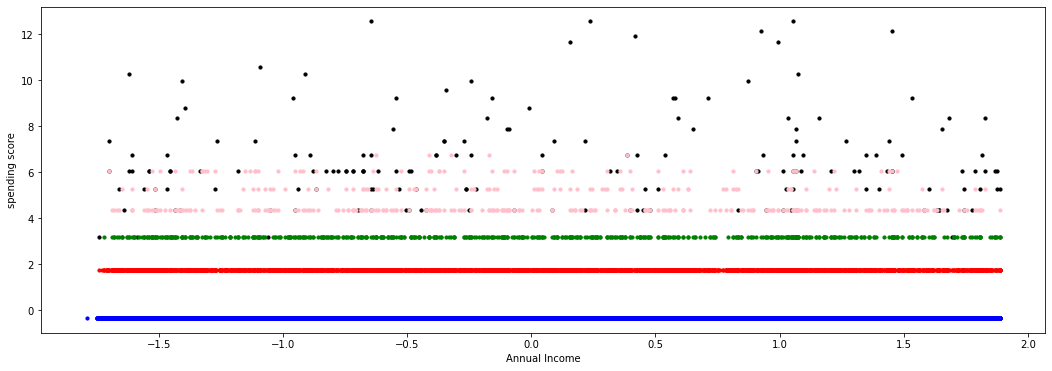

In [74]:
fig = plt.figure(1, figsize=(18, 6))
plt.scatter(rfm_std_2.iloc[labels==-1,0],rfm_std_2.iloc[labels==-1,1],s=10,c='black')
plt.scatter(rfm_std_2.iloc[labels==0,0],rfm_std_2.iloc[labels==0,1],s=10,c='blue')
plt.scatter(rfm_std_2.iloc[labels==1,0],rfm_std_2.iloc[labels==1,1],s=10,c='red')
plt.scatter(rfm_std_2.iloc[labels==2,0],rfm_std_2.iloc[labels==2,1],s=10,c='green')
plt.scatter(rfm_std_2.iloc[labels==3,0],rfm_std_2.iloc[labels==3,1],s=10,c='pink')
plt.scatter(rfm_std_2.iloc[labels==4,0],rfm_std_2.iloc[labels==4,1],s=10,c='yellow')
plt.xlabel('Annual Income')
plt.ylabel('spending score')
plt.show()


# Clustering hiérarchique

In [361]:
# Step 3: Preprocessing the data
from sklearn.preprocessing import normalize
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_std_1)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [362]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.45267296 0.35558296 0.15361777]
[0.4706158 0.3696774 0.1597068]


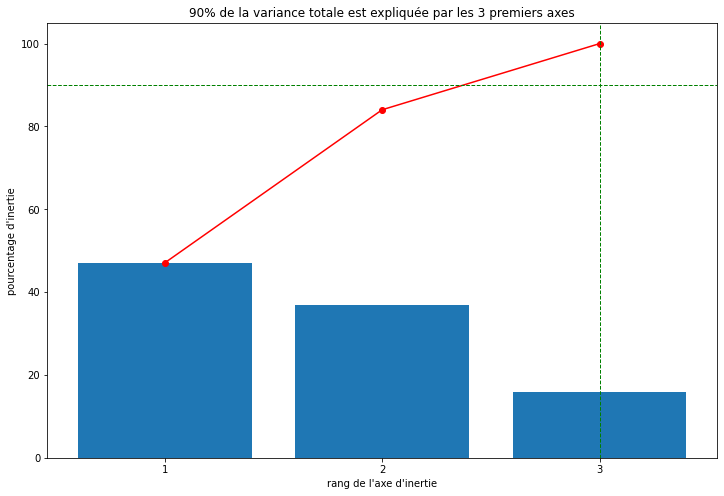

In [363]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [364]:
# 4 : Réduire la dimensionnalité des Données

pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [365]:
import numpy as np
from sklearn.model_selection import train_test_split

In [366]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

In [367]:
X_train.shape

(14953, 2)

In [368]:
from scipy.cluster.hierarchy import linkage,dendrogram
fusions = linkage(X_train, method='complete', metric='euclidean')

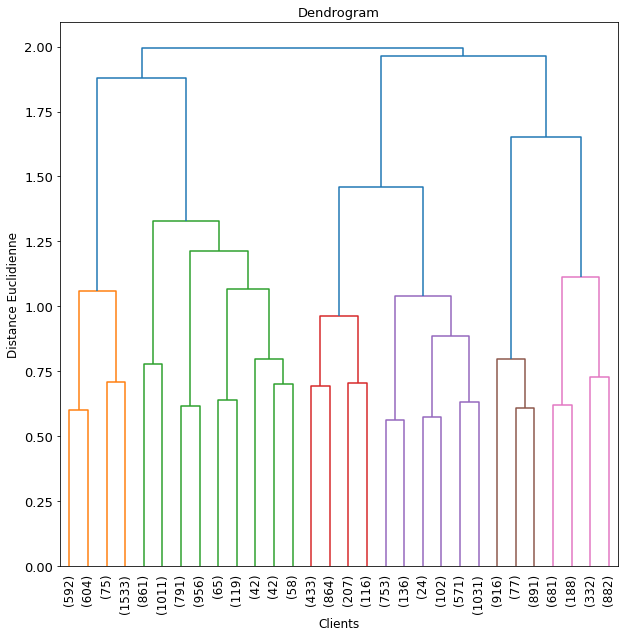

In [369]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

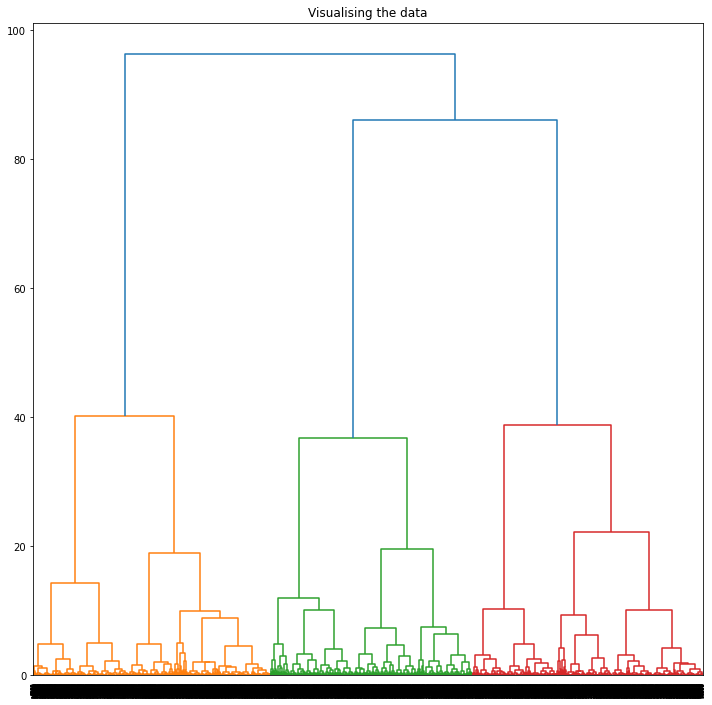

In [370]:
# Dendograms are used to divide a given cluster into many different clusters.
import scipy.cluster.hierarchy as shc
# Step 5: Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

In [371]:
y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

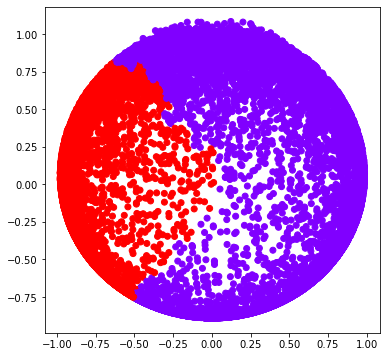

In [372]:
# Step 6: Building and Visualizing the different clustering models for different values of k
# k = 2
from sklearn.cluster import AgglomerativeClustering
ac2 = AgglomerativeClustering(n_clusters = 2)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac2.fit_predict(y_test), cmap ='rainbow')
plt.show()

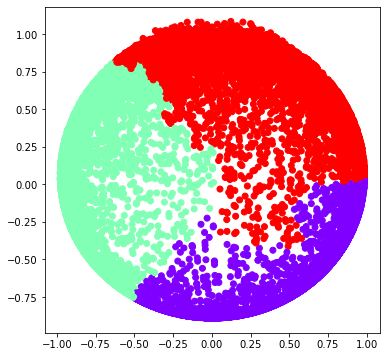

In [373]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

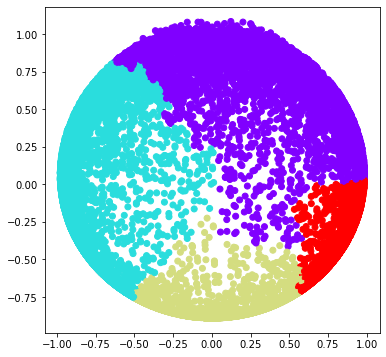

In [374]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

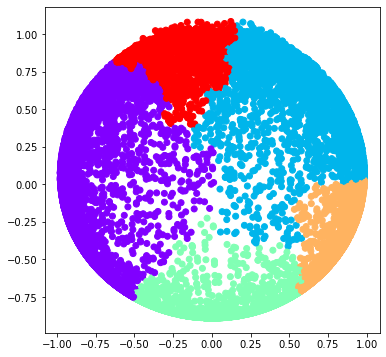

In [375]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac5.fit_predict(y_test), cmap ='rainbow')
plt.show()

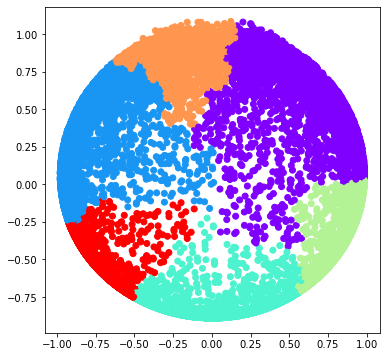

In [376]:
# k = 6

ac6 = AgglomerativeClustering(n_clusters = 6)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac6.fit_predict(y_test), cmap ='rainbow')
plt.show()

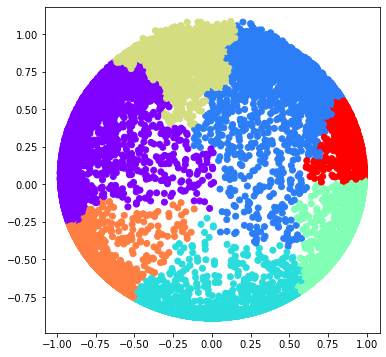

In [377]:
# k = 7

ac7 = AgglomerativeClustering(n_clusters = 7)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac7.fit_predict(y_test), cmap ='rainbow')
plt.show()

In [383]:
# Step 7: Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac5.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac6.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac7.fit_predict(y_test)))

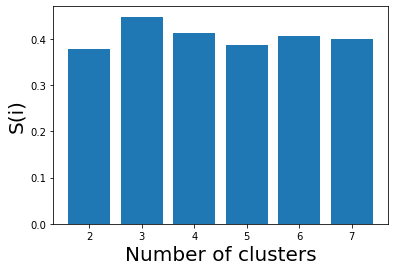

In [384]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

In [385]:
Xbis_train,Xbis_test   = train_test_split(
                     X_normalized,  test_size=0.8, random_state=0)

In [386]:
Xbis_train.shape

(14953, 3)

In [387]:
fusions1 = linkage(Xbis_train, method='complete', metric='euclidean')

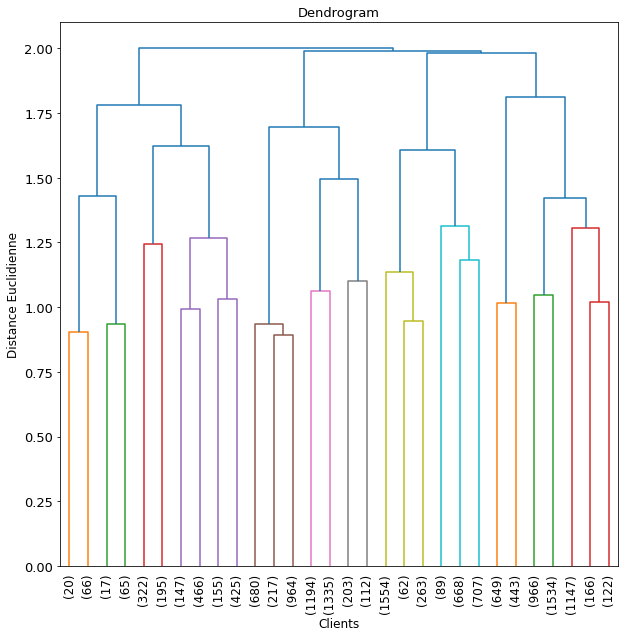

In [388]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions1,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

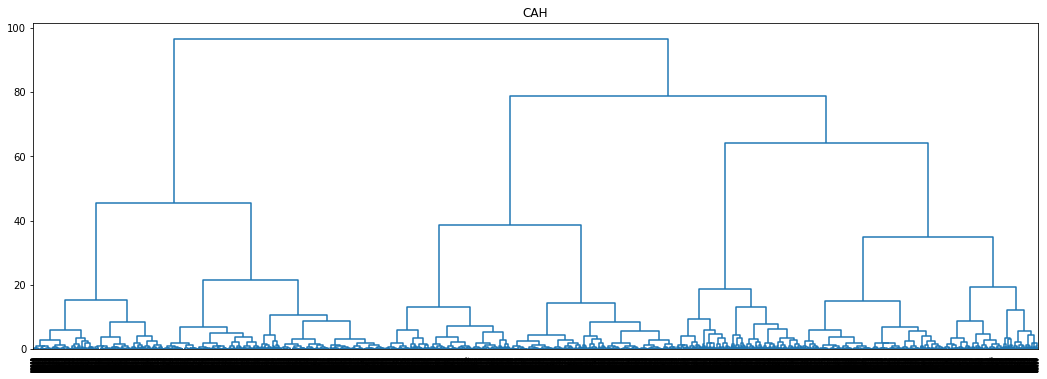

In [389]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(Xbis_train,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.figure(figsize =(18, 6))
plt.title("CAH")
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=0)
plt.show()

In [390]:
fusions3 = linkage(X_train, method='complete', metric='euclidean')

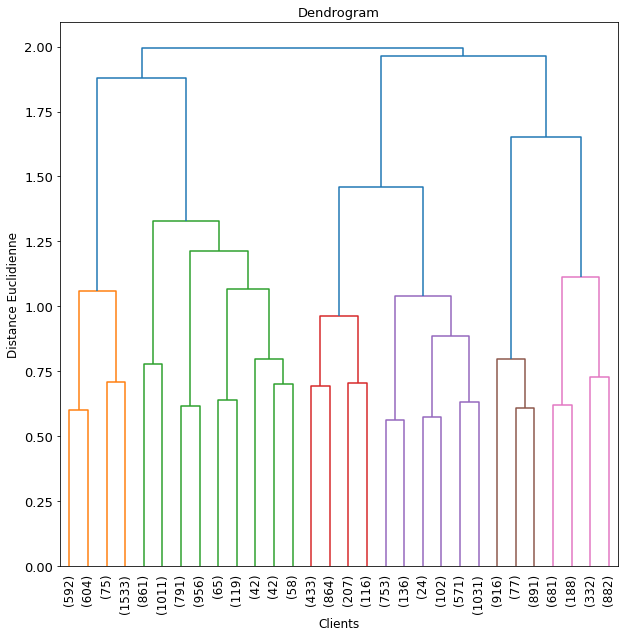

In [391]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions3,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

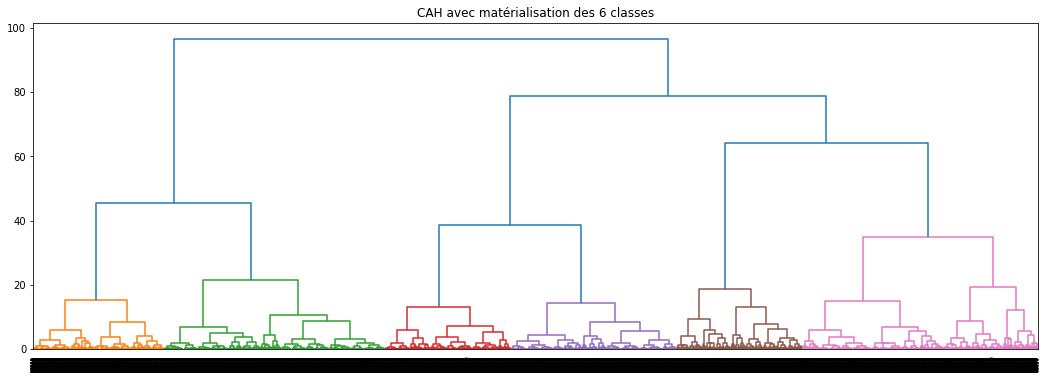

[6 6 6 ... 4 3 3]
        0
1   69088
1   21508
1   71653
1   37060
1   10770
..    ...
6   66044
6   63875
6   70528
6   41543
6   26211

[14953 rows x 1 columns]


In [392]:
from scipy.cluster.hierarchy import ward, fcluster
#matérialisation des 6 classes (hauteur t = 38
plt.figure(figsize =(18, 6))
plt.title('CAH avec matérialisation des 6 classes')
dendrogram(Z,labels=Xbis_train.index,orientation='top',color_threshold=38)
plt.show()
#découpage à la hauteur t = 38==> identifiants de 6 groupes obtenus
groupes_cah = fcluster(Z,t=38,criterion='distance')
print(groupes_cah)
#index triés des groupes
idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
print(pd.DataFrame(X_train.index[idg],groupes_cah[idg]))

In [393]:
import sklearn.metrics as metrics
for i in range(2,8):
    
        selected_model = AgglomerativeClustering(n_clusters=i)
        selected_model.fit(X_train)
        print("silhouette score : {:.2f}".format(metrics.silhouette_score(X_train, selected_model.labels_)))


silhouette score : 0.39
silhouette score : 0.48
silhouette score : 0.43
silhouette score : 0.40
silhouette score : 0.41
silhouette score : 0.42


# Conclusion
- L'algorithme DBSCAN ne semble pas faire du bon travail et je ne peux pas l'utiliser sur le jeu de données complet (manque de mémoire) donc nous ne l'utiliserons pas
- Le clustering hiérarchique donne des résultats intéressants mais je ne peux pas l'utiliser sur le jeu de données qu'avec reduction de dimension (manque de mémoire)
- KMeans donne de bons résultats et peut être utilisé sur l'ensemble de données complet --> nous utiliserons cet algorithme
Les résultats les plus intéressants sont avec les variables "customer_id", "purchase_time", "payment_value", avec 6 clusters

In [75]:
# Calcul RFM avec la même méthode,
# mais en ajoutant une période de 30 jours en arvant
rfm_table_2 = calculate_rfm(data, period, today + timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais en ajoutant une période de 60 jours en arvant
rfm_table_3 = calculate_rfm(data, period, today + timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais en ajoutant une période de 90 jours en arvant
rfm_table_4 = calculate_rfm(data, period, today + timedelta(days=90))

In [76]:
rfm_table_2.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      323          1    114.74
1  000379cdec625522490c315e70c7a9fb      184          1    107.01
2  000419c5494106c306a97b5635748086      215          1     49.40
3  00046a560d407e99b969756e0b10f282      289          1    166.59
4  000598caf2ef4117407665ac33275130       53          1   1255.71

In [77]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_2 = rfm_table_2.copy()
rfm_log_2[["Frequency",
           "Monetary"]] = rfm_log_2[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

In [78]:
rfm_2 = calculate_quantile(rfm_table_2)

In [79]:
# RFM Score
rfm_2["RFM Score"] = rfm_2.apply(calculate_segments, axis=1)

In [80]:
rfm_2.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      323          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      184          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      215          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      289          1    166.59  2  1  4   
4  000598caf2ef4117407665ac33275130       53          1   1255.71  5  1  5   

            RFM Score  
0              Others  
1  Potential Loyalist  
2  Potential Loyalist  
3              Others  
4    Recent Customers

In [81]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_2 = encoder.fit_transform(
    rfm_log_2[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_2 = pd.DataFrame(x_transformed_2,
                         index=rfm_2.index,
                         columns=["Recency", "Frequency", "Monetary"])

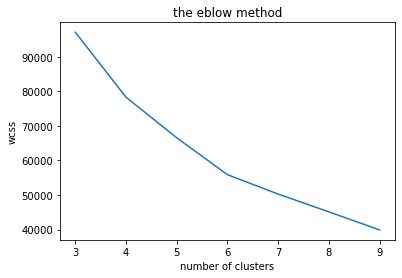

In [82]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_2)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the eblow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

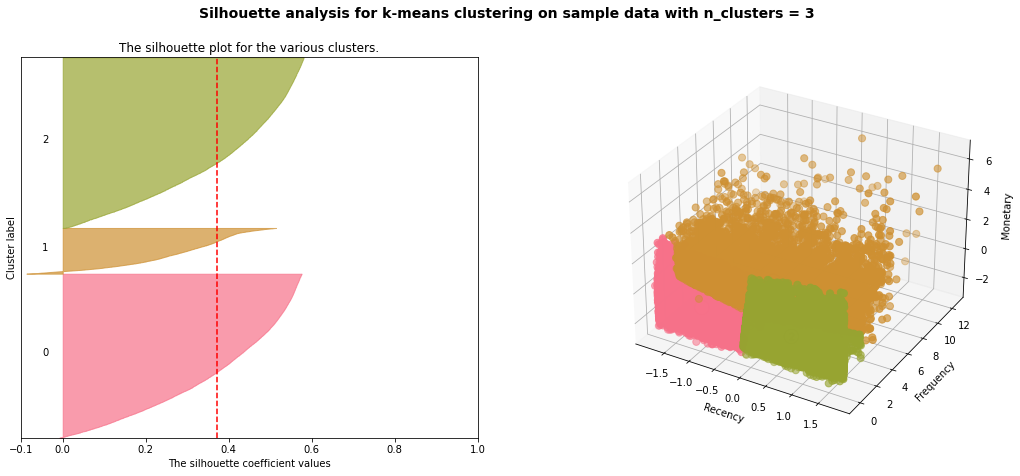

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.37 
 Le temps d'entrainement du modèle est de : 0.14


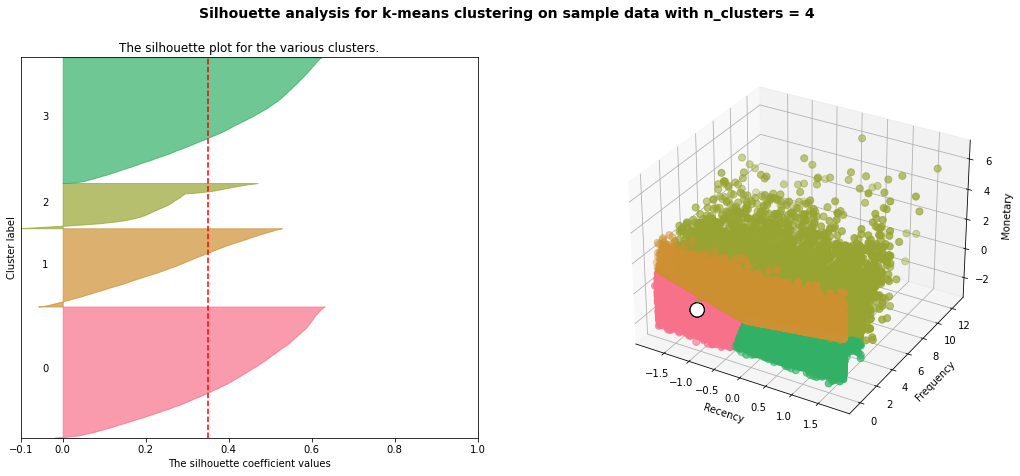

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 0.34


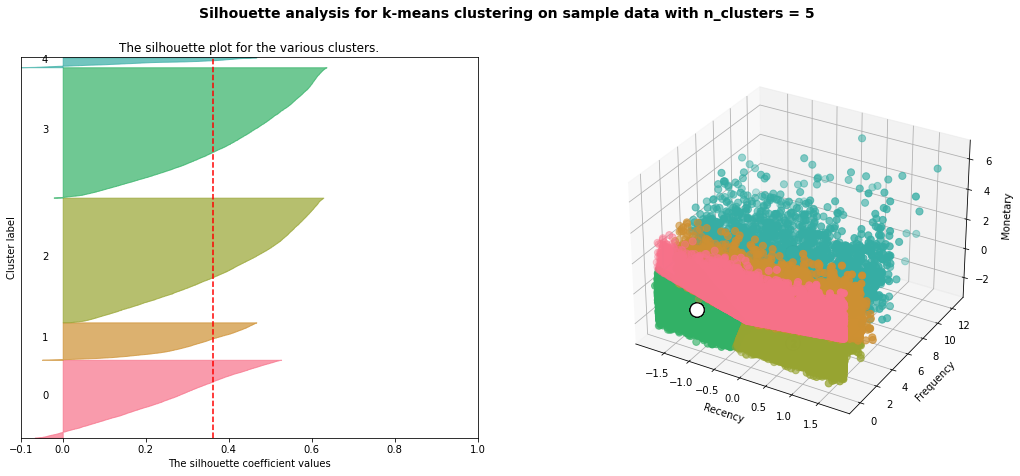

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.36 
 Le temps d'entrainement du modèle est de : 0.37


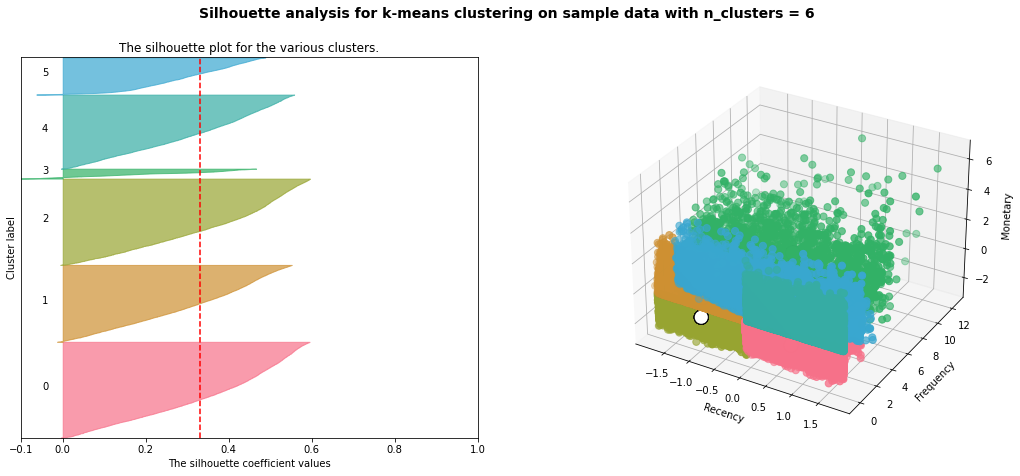

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.32


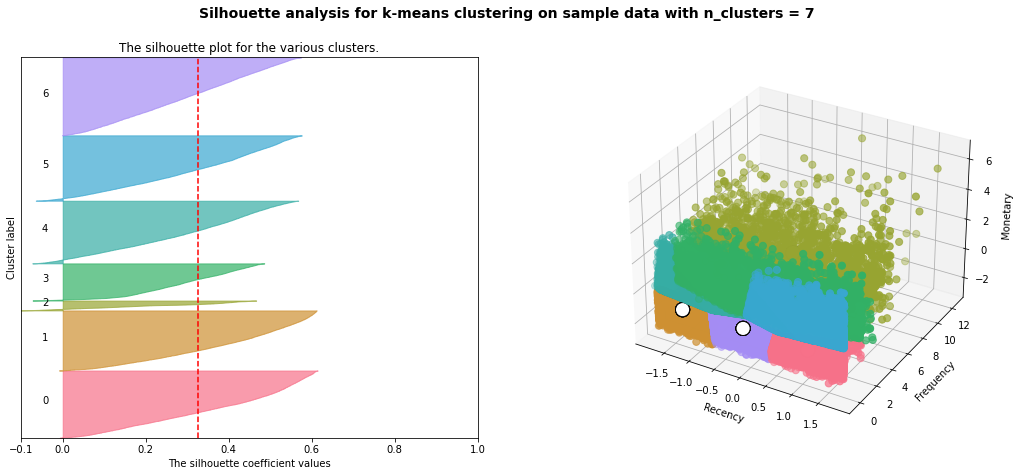

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.29


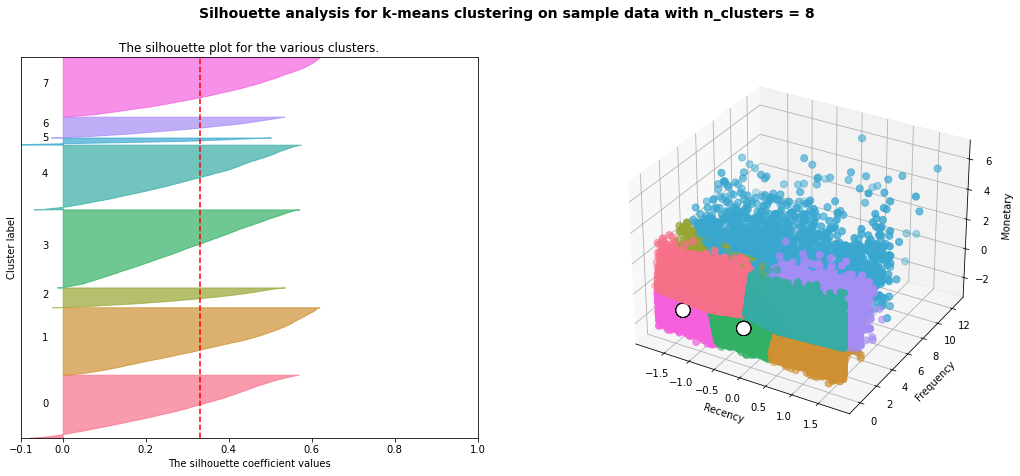

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.42


In [99]:
range_n_clusters = range(3, 9)
fit_predict_time_2 = clustering_rfm(rfm_std_2,range_n_clusters)

In [86]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 2
clusters = kmeans.fit_predict(x_transformed_2)
rfm_2['clusters'] = clusters

In [87]:
# Renommage des différents clusters et regroupement
rfm_2.loc[rfm_2["clusters"] ==
                3, "clusters"] = 'Good Clients'

rfm_2.loc[rfm_2["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_2.loc[rfm_2["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_2.loc[rfm_2["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_2.loc[rfm_2["clusters"] ==
                0, "clusters"] = 'Others'

rfm_2.loc[rfm_2["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

In [88]:
rfm_2.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      323          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      184          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      215          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      289          1    166.59  2  1  4   
4  000598caf2ef4117407665ac33275130       53          1   1255.71  5  1  5   

            RFM Score            clusters  
0              Others      Top Clients ++  
1  Potential Loyalist    Recent Customers  
2  Potential Loyalist  Potential Loyalist  
3              Others      Top Clients ++  
4    Recent Customers    Recent Customers

In [89]:
rfm_table_3.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      353          1    114.74
1  000379cdec625522490c315e70c7a9fb      214          1    107.01
2  000419c5494106c306a97b5635748086      245          1     49.40
3  00046a560d407e99b969756e0b10f282      319          1    166.59
4  000598caf2ef4117407665ac33275130       83          1   1255.71

In [90]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_3 = rfm_table_3.copy()
rfm_log_3[["Frequency",
           "Monetary"]] = rfm_log_3[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

In [91]:
rfm_3 = calculate_quantile(rfm_table_3)

In [92]:
# RFM Score
rfm_3["RFM Score"] = rfm_3.apply(calculate_segments, axis=1)

In [93]:
rfm_3.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      353          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      214          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      245          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      319          1    166.59  1  1  4   
4  000598caf2ef4117407665ac33275130       83          1   1255.71  5  1  5   

            RFM Score  
0              Others  
1  Potential Loyalist  
2  Potential Loyalist  
3              Others  
4    Recent Customers

In [94]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_3 = encoder.fit_transform(
    rfm_log_3[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_3 = pd.DataFrame(x_transformed_3,
                         index=rfm_3.index,
                         columns=["Recency", "Frequency", "Monetary"])

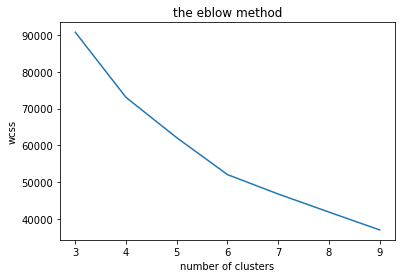

In [95]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_3)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the eblow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

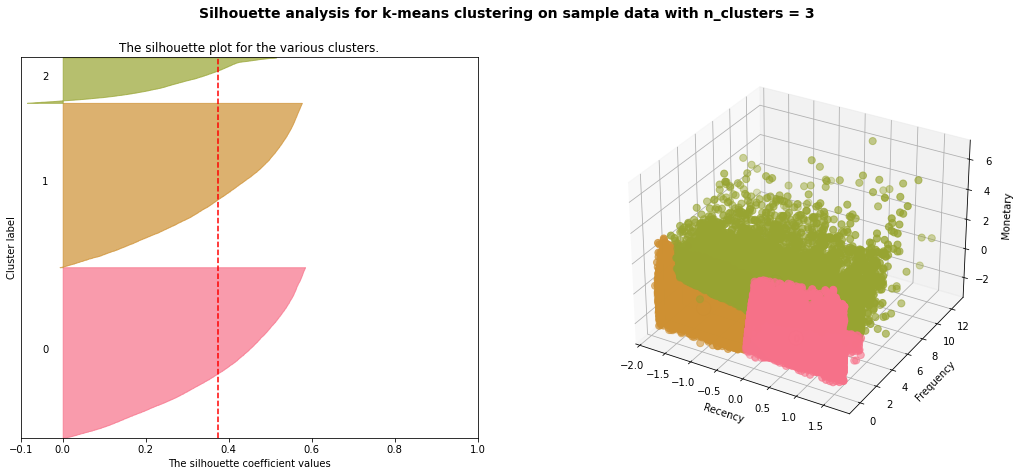

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.37 
 Le temps d'entrainement du modèle est de : 0.13


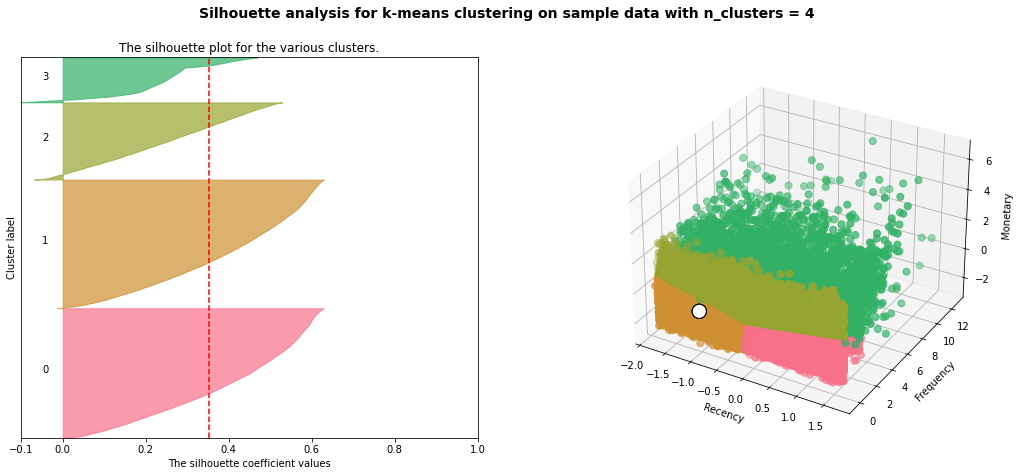

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 0.3


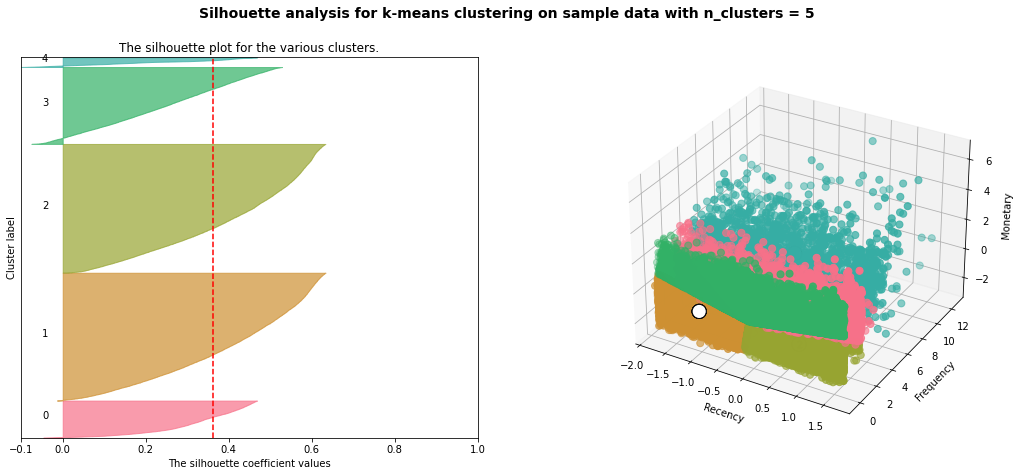

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.36 
 Le temps d'entrainement du modèle est de : 0.35


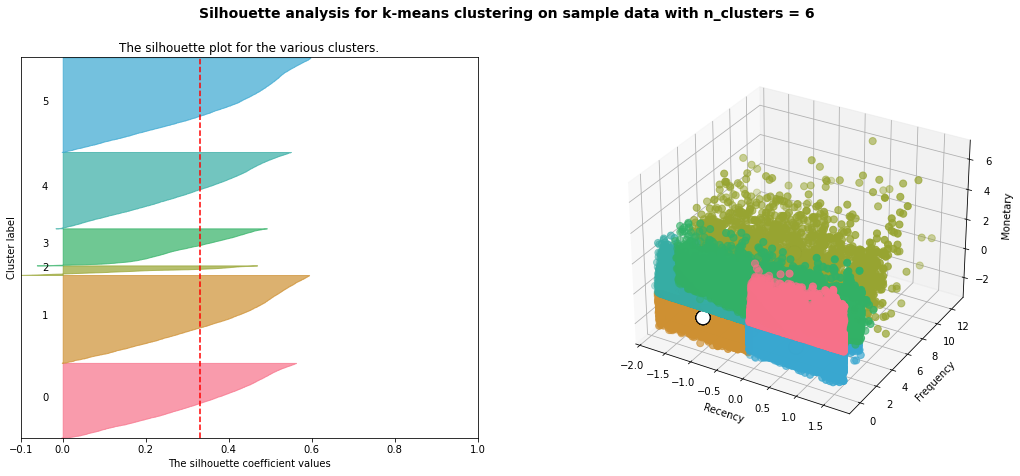

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.29


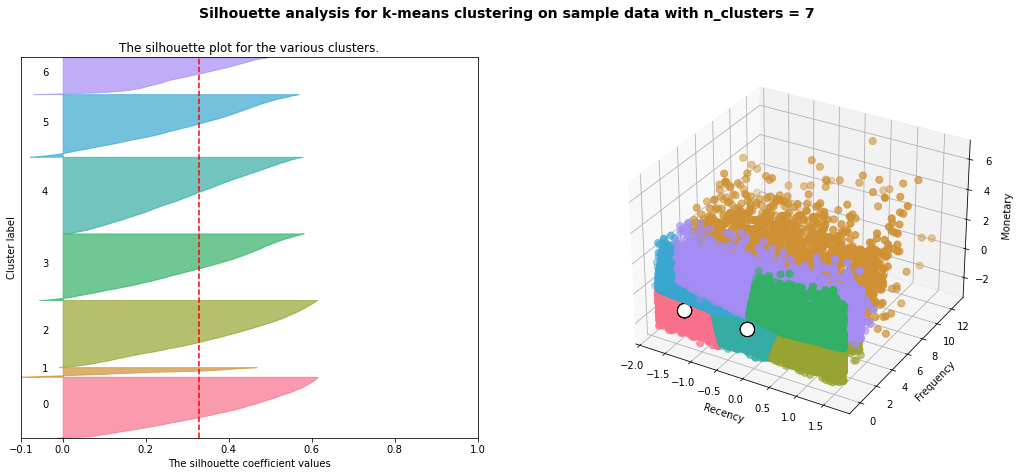

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.32


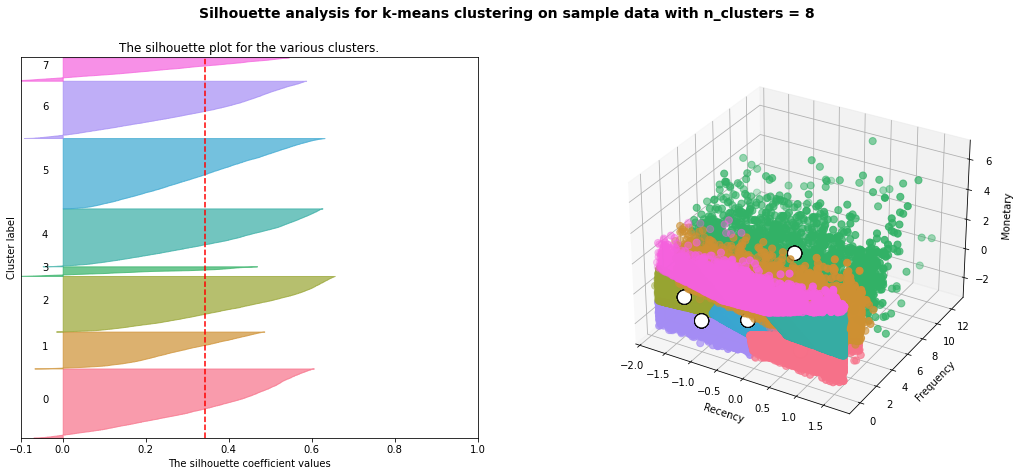

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.34 
 Le temps d'entrainement du modèle est de : 0.35


In [110]:
range_n_clusters = range(3, 9)
fit_predict_time_3 = clustering_rfm(rfm_std_3,range_n_clusters)

In [99]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 3
clusters = kmeans.fit_predict(x_transformed_3)
rfm_3['clusters'] = clusters

In [100]:
# Renommage des différents clusters et regroupement
rfm_3.loc[rfm_3["clusters"] ==
                3, "clusters"] = 'Good Clients'

rfm_3.loc[rfm_3["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_3.loc[rfm_3["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_3.loc[rfm_3["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_3.loc[rfm_3["clusters"] ==
                0, "clusters"] = 'Others'

rfm_3.loc[rfm_3["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

In [101]:
rfm_3.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      353          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      214          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      245          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      319          1    166.59  1  1  4   
4  000598caf2ef4117407665ac33275130       83          1   1255.71  5  1  5   

            RFM Score            clusters  
0              Others  Potential Loyalist  
1  Potential Loyalist      Top Clients ++  
2  Potential Loyalist              Others  
3              Others  Potential Loyalist  
4    Recent Customers    Recent Customers

In [102]:
rfm_table_4.head()

customer_id  Recency  Frequency  Monetary
0  000379cdec625522490c315e70c7a9fb      244          1    107.01
1  000419c5494106c306a97b5635748086      275          1     49.40
2  00046a560d407e99b969756e0b10f282      349          1    166.59
3  000598caf2ef4117407665ac33275130      113          1   1255.71
4  0005aefbb696d34b3424dccd0a0e9fd0      165          1    147.33

In [103]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_4 = rfm_table_4.copy()
rfm_log_4[["Frequency",
           "Monetary"]] = rfm_log_4[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

In [104]:
rfm_4 = calculate_quantile(rfm_table_4)

In [105]:
# RFM Score
rfm_4["RFM Score"] = rfm_4.apply(calculate_segments, axis=1)

In [106]:
rfm_4.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      244          1    107.01  3  1  3   
1  000419c5494106c306a97b5635748086      275          1     49.40  2  1  1   
2  00046a560d407e99b969756e0b10f282      349          1    166.59  1  1  4   
3  000598caf2ef4117407665ac33275130      113          1   1255.71  5  1  5   
4  0005aefbb696d34b3424dccd0a0e9fd0      165          1    147.33  4  1  4   

            RFM Score  
0  Potential Loyalist  
1      About to Sleep  
2              Others  
3    Recent Customers  
4    Recent Customers

In [107]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_4 = encoder.fit_transform(
    rfm_log_4[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_4 = pd.DataFrame(x_transformed_4,
                         index=rfm_4.index,
                         columns=["Recency", "Frequency", "Monetary"])

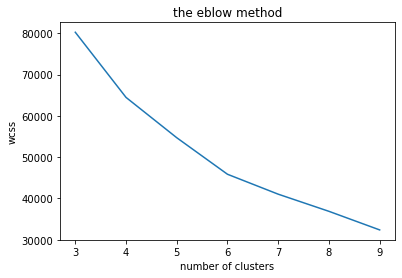

In [108]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_4)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the eblow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

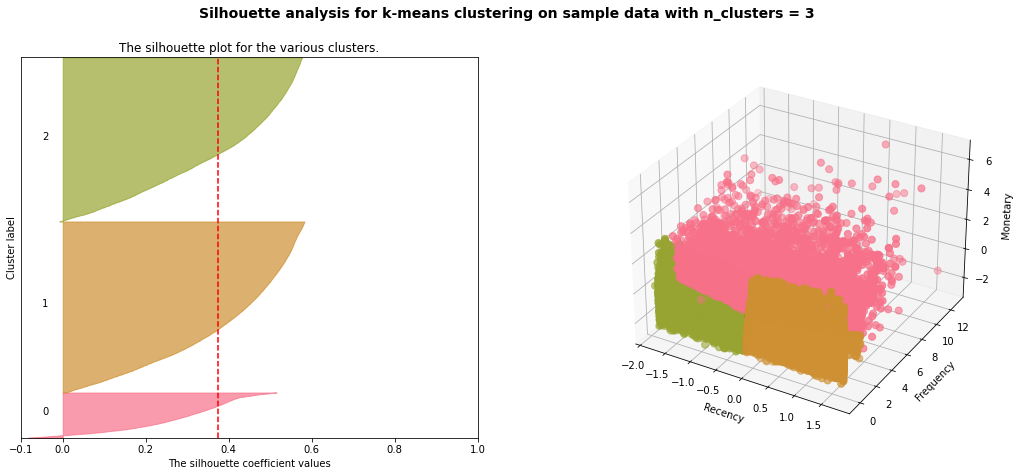

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.37 
 Le temps d'entrainement du modèle est de : 0.13


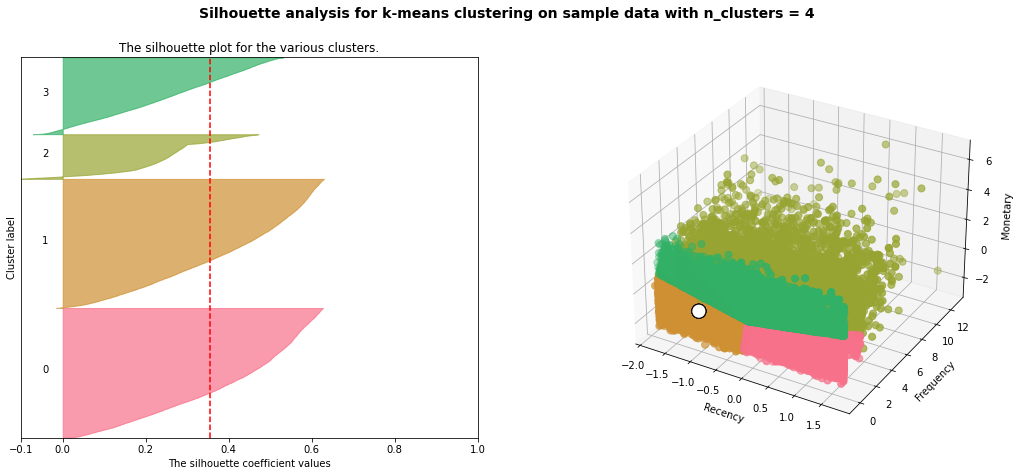

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 0.23


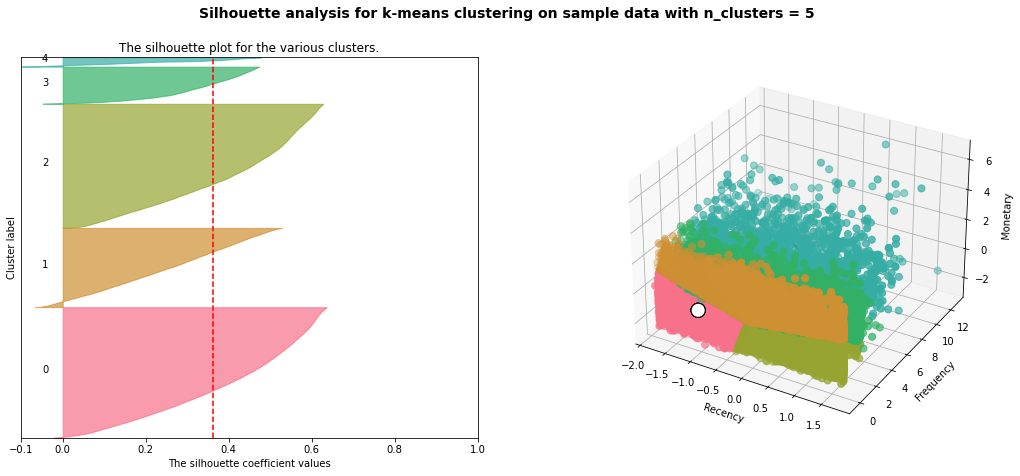

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.36 
 Le temps d'entrainement du modèle est de : 0.29


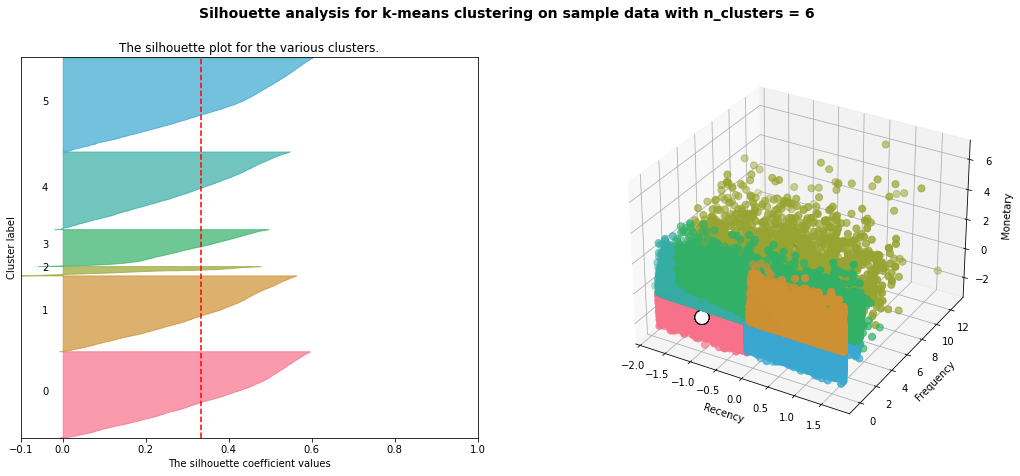

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.25


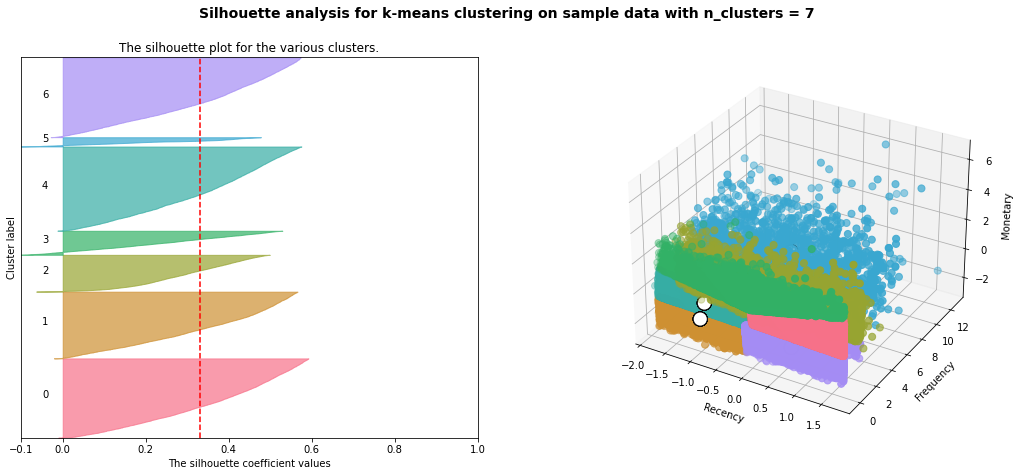

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 0.27


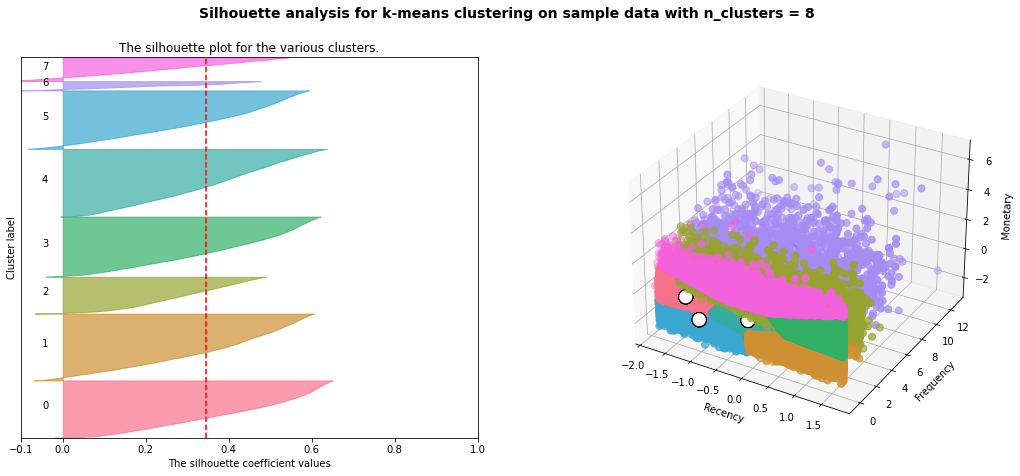

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 0.3


In [122]:
range_n_clusters = range(3, 9)
fit_predict_time_4 = clustering_rfm(rfm_std_4,range_n_clusters)

In [112]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 4
clusters = kmeans.fit_predict(x_transformed_4)
rfm_4['clusters'] = clusters

In [115]:
# Renommage des différents clusters et regroupement
rfm_4.loc[rfm_4["clusters"] ==
                3, "clusters"] = 'Good Clients'

rfm_4.loc[rfm_4["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_4.loc[rfm_4["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_4.loc[rfm_4["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_4.loc[rfm_4["clusters"] ==
               0, "clusters"] = 'Others'

rfm_4.loc[rfm_4["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

In [116]:
rfm_4.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      244          1    107.01  3  1  3   
1  000419c5494106c306a97b5635748086      275          1     49.40  2  1  1   
2  00046a560d407e99b969756e0b10f282      349          1    166.59  1  1  4   
3  000598caf2ef4117407665ac33275130      113          1   1255.71  5  1  5   
4  0005aefbb696d34b3424dccd0a0e9fd0      165          1    147.33  4  1  4   

            RFM Score                clusters  
0  Potential Loyalist          Top Clients ++  
1      About to Sleep          Top Clients ++  
2              Others  Lost or About to Sleep  
3    Recent Customers            Good Clients  
4    Recent Customers            Good Clients

In [117]:

rfm_table_5 = calculate_rfm(data, period, today + timedelta(days=120))
rfm_table_6 = calculate_rfm(data, period, today + timedelta(days=150))

In [118]:
rfm_table_5.head()

customer_id  Recency  Frequency  Monetary
0  000379cdec625522490c315e70c7a9fb      274          1    107.01
1  000419c5494106c306a97b5635748086      305          1     49.40
2  000598caf2ef4117407665ac33275130      143          1   1255.71
3  0005aefbb696d34b3424dccd0a0e9fd0      195          1    147.33
4  00066ccbe787a588c52bd5ff404590e3      329          4   1080.00

In [119]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_5 = rfm_table_5.copy()
rfm_log_5[["Frequency",
           "Monetary"]] = rfm_log_5[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

In [120]:
rfm_5 = calculate_quantile(rfm_table_5)

In [121]:
# RFM Score
rfm_5["RFM Score"] = rfm_5.apply(calculate_segments, axis=1)

In [122]:
rfm_5.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      274          1    107.01  3  1  3   
1  000419c5494106c306a97b5635748086      305          1     49.40  2  1  1   
2  000598caf2ef4117407665ac33275130      143          1   1255.71  5  1  5   
3  0005aefbb696d34b3424dccd0a0e9fd0      195          1    147.33  4  1  4   
4  00066ccbe787a588c52bd5ff404590e3      329          4   1080.00  1  5  5   

            RFM Score  
0  Potential Loyalist  
1      About to Sleep  
2    Recent Customers  
3    Recent Customers  
4     Can't Lose Them

In [123]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_5 = encoder.fit_transform(
    rfm_log_5[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_5 = pd.DataFrame(x_transformed_5,
                         index=rfm_5.index,
                         columns=["Recency", "Frequency", "Monetary"])

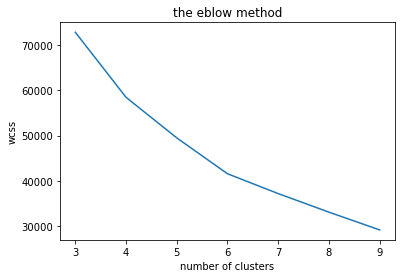

In [124]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_5)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the eblow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

In [128]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 5
clusters = kmeans.fit_predict(x_transformed_5)
rfm_5['clusters'] = clusters

In [129]:
# Renommage des différents clusters et regroupement
rfm_5.loc[rfm_5["clusters"] ==
                3, "clusters"] = 'Good Clients'

rfm_5.loc[rfm_5["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_5.loc[rfm_5["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_5.loc[rfm_5["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_5.loc[rfm_5["clusters"] ==
                0, "clusters"] = 'Others'

rfm_5.loc[rfm_5["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

In [130]:
rfm_5.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      274          1    107.01  3  1  3   
1  000419c5494106c306a97b5635748086      305          1     49.40  2  1  1   
2  000598caf2ef4117407665ac33275130      143          1   1255.71  5  1  5   
3  0005aefbb696d34b3424dccd0a0e9fd0      195          1    147.33  4  1  4   
4  00066ccbe787a588c52bd5ff404590e3      329          4   1080.00  1  5  5   

            RFM Score            clusters  
0  Potential Loyalist        Good Clients  
1      About to Sleep        Good Clients  
2    Recent Customers  Potential Loyalist  
3    Recent Customers  Potential Loyalist  
4     Can't Lose Them      Top Clients ++

In [131]:
rfm_table_6.head()

customer_id  Recency  Frequency  Monetary
0  000379cdec625522490c315e70c7a9fb      304          1    107.01
1  000419c5494106c306a97b5635748086      335          1     49.40
2  000598caf2ef4117407665ac33275130      173          1   1255.71
3  0005aefbb696d34b3424dccd0a0e9fd0      225          1    147.33
4  00066ccbe787a588c52bd5ff404590e3      359          4   1080.00

In [132]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_6 = rfm_table_6.copy()
rfm_log_6[["Frequency",
           "Monetary"]] = rfm_log_6[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

In [133]:
rfm_6 = calculate_quantile(rfm_table_6)

In [134]:
# RFM Score
rfm_6["RFM Score"] = rfm_6.apply(calculate_segments, axis=1)

In [135]:
rfm_6.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      304          1    107.01  2  1  3   
1  000419c5494106c306a97b5635748086      335          1     49.40  1  1  1   
2  000598caf2ef4117407665ac33275130      173          1   1255.71  5  1  5   
3  0005aefbb696d34b3424dccd0a0e9fd0      225          1    147.33  4  1  4   
4  00066ccbe787a588c52bd5ff404590e3      359          4   1080.00  1  5  5   

          RFM Score  
0            Others  
1              Lost  
2  Recent Customers  
3  Recent Customers  
4   Can't Lose Them

In [136]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_6 = encoder.fit_transform(
    rfm_log_6[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_6 = pd.DataFrame(x_transformed_6,
                         index=rfm_6.index,
                         columns=["Recency", "Frequency", "Monetary"])

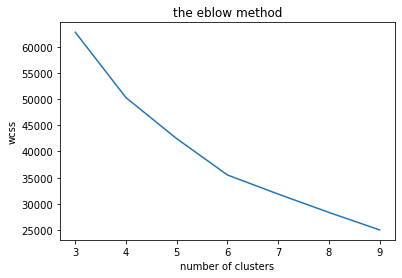

In [137]:
wcss=[]
for i in range(3,10):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(rfm_std_6)
    wcss.append(kmeans.inertia_)
plt.plot(range(3,10), wcss)
plt.title("the eblow method")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

In [138]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 6
clusters = kmeans.fit_predict(x_transformed_6)
rfm_6['clusters'] = clusters

In [139]:
# Renommage des différents clusters et regroupement
rfm_6.loc[rfm_6["clusters"] ==
                3, "clusters"] = 'Good Clients'

rfm_6.loc[rfm_6["clusters"] ==
                5, "clusters"] = 'Recent Customers'

rfm_6.loc[rfm_6["clusters"] ==
                4, "clusters"] = 'Lost or About to Sleep'

rfm_6.loc[rfm_6["clusters"] ==
                1, "clusters"] = 'Potential Loyalist'

rfm_6.loc[rfm_6["clusters"] ==
                0, "clusters"] = 'Others'

rfm_6.loc[rfm_6["clusters"] ==
                2, "clusters"] = 'Top Clients ++'

In [140]:
rfm_6.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  000379cdec625522490c315e70c7a9fb      304          1    107.01  2  1  3   
1  000419c5494106c306a97b5635748086      335          1     49.40  1  1  1   
2  000598caf2ef4117407665ac33275130      173          1   1255.71  5  1  5   
3  0005aefbb696d34b3424dccd0a0e9fd0      225          1    147.33  4  1  4   
4  00066ccbe787a588c52bd5ff404590e3      359          4   1080.00  1  5  5   

          RFM Score                clusters  
0            Others      Potential Loyalist  
1              Lost      Potential Loyalist  
2  Recent Customers  Lost or About to Sleep  
3  Recent Customers  Lost or About to Sleep  
4   Can't Lose Them          Top Clients ++

In [141]:
# Sauvegarde des DataFrames RFM
rfm_table_1.to_csv('df_1.csv')
rfm_2.to_csv('df_2.csv')
rfm_3.to_csv('df_3.csv')
rfm_4.to_csv('df_4.csv')
rfm_5.to_csv('df_5.csv')
rfm_6.to_csv('df_6.csv')